In [1]:
#!/usr/bin/env python3

import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")
from multiprocessing import Pool,cpu_count
from functools import partial
from scipy import sparse
from scipy import stats
import pickle
import datetime
import argparse
import logging

import snmcseq_utils
from __init__ import *
from __init__jupyterlab import *

import CEMBA_clst_utils
import fbpca

In [2]:
def turn_cluster_labels_to_knn(cluster_labels, uniq_labels):
    """
    """
    
    clst_idx = snmcseq_utils.get_index_from_array(uniq_labels, cluster_labels)
    m, n = len(clst_idx), len(uniq_labels)
    _i = np.arange(m)
    _j = clst_idx
    _data = [1]*m
    knn = sparse.coo_matrix((_data, (_i, _j)), shape=(m, n)) 
    return knn



In [3]:
def row_dot_product_norm_by_numcol(X_zscore, Y_zscore, x_idx, y_idx, 
                                   chunksize=100000, verbose_level=100000):
    """compute (X_zscore[x_idx]*Y_zscore[y_idx]).mean(axis=1)
    correlation values given matched x_idx and y_idx...
    """
    ti = time.time()
    
    assert len(x_idx) == len(y_idx)
    num_pairs = len(x_idx)
    corrs = []
    for pair_idx in snmcseq_utils.chunks(np.arange(num_pairs), chunksize):
        if verbose_level and pair_idx[0] % verbose_level == 0:
            print(pair_idx[0], time.time()-ti)

        _res = (X_zscore[x_idx[pair_idx]]*Y_zscore[y_idx[pair_idx]]).mean(axis=1)
        corrs.append(_res)
    corrs = np.hstack(corrs) 
    return corrs 

In [4]:
def compute_enh_gene_corrs(gc_rna, ec_mccg, 
    enhancer_gene_to_eval, 
    common_genes, common_enhancers,
    output_file='', **kwargs,
    ):
    """
    gc_rna: enh-by-cell RNA matrix
    ec_mccg: enh-by-cell mC matrix
    enhancer_gene_to_eval: a table with enhancer-gene pairs need to be ...
    
    common_genes: orders gene in the mat gc_rna
    common_enhancers: orders of enh in the mat ec_mccg (ec_mccg.index.values)
    
    """
    common_enhancers = ec_mccg.index.values
    
    gc_rna_zscore = stats.zscore(np.array(gc_rna), axis=1, ddof=0, nan_policy='propagate')
    ec_mccg_zscore = stats.zscore(np.array(ec_mccg), axis=1, ddof=0, nan_policy='propagate')
    
    # correlate e-g according to a e-g table
    gene_idx = snmcseq_utils.get_index_from_array(common_genes, enhancer_gene_to_eval['gene'])
    enh_idx = snmcseq_utils.get_index_from_array(common_enhancers, enhancer_gene_to_eval['ens']) # be careful here!
    to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)
    
    gene_idx = gene_idx[to_correlate]
    enh_idx = enh_idx[to_correlate]
    
    # corr
    corrs = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx, **kwargs)
    
    # corr shuffled cells
    corrs_shuffled_cells = row_dot_product_norm_by_numcol(
        gc_rna_zscore[:,np.random.permutation(gc_rna_zscore.shape[1])], 
        ec_mccg_zscore, 
        gene_idx, enh_idx, **kwargs)

    # corr shuffled genes (break up the pairs)
    gene_idx_uniq = np.unique(gene_idx)
    shuff_genes = {
        gene: gene_shuff for gene, gene_shuff in 
            zip(gene_idx_uniq, gene_idx_uniq[np.random.permutation(len(gene_idx_uniq))])
        }
    gene_idx_shuff = np.array([shuff_genes[gene] for gene in gene_idx])

    corrs_shuffled = row_dot_product_norm_by_numcol(
        gc_rna_zscore, 
        ec_mccg_zscore, 
        gene_idx_shuff, enh_idx, **kwargs)
    
    # save corrs 
    if output_file:
        with open(output_file, 'wb') as fh:
            pickle.dump((to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells), fh)
        
    return to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells

In [5]:
# def create_parser():
#     """
#     """
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-tag', '--input_name_tag', required=True, type=str)
#     parser.add_argument('-modx', '--mod_x', required=True, type=str)
#     parser.add_argument('-mody', '--mod_y', required=True, type=str)

#     parser.add_argument('-knn', '--knn_across', required=True, type=int)
#     parser.add_argument('-ka', '--knn_within', required=True, type=int)
#     parser.add_argument('-dt', '--result_date', type=str, help="eg: 200803")
#     parser.add_argument('-isub', '--i_sub', type=str, help="[0-9]")
#     return parser

In [6]:
ti = time.time()

# parser = create_parser()
# args = parser.parse_args()
logger = snmcseq_utils.create_logger()

# # set up 
# input_name_tag = args.input_name_tag
# mod_x = args.mod_x
# mod_y = args.mod_y

# knn = args.knn_across 
# ka = args.knn_within 
# result_date = args.result_date
# i_sub = args.i_sub

# set up 
input_name_tag = 'mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201120'
mod_x = '10x_cells_v3'
mod_y = 'snmcseq_gene'

knn = 30 
ka = 30 
result_date = 201120 
# i_sub = 0

In [7]:
# set up data directories

name = "corr_analysis_{}_{}_{}".format(mod_x, mod_y, input_name_tag) 
logging.info(name)
output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{{}}_corrs.pkl'.format(name)
output_figures = "/cndd2/fangming/projects/scf_enhancers/results/figures/{}_{{}}.pdf".format(name) 

input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
bundle_fnames = (
    'cell_10x_cells_v3.txt',
    'cell_snmcseq_gene.txt',

    'gene_10x_cells_v3.txt',
    'enh.tsv',

    'mat_10x_cells_v3.npz',
    'mat_mcg_snmcseq_gene.npz',
    'mat_cg_snmcseq_gene.npz',
)

# input knn networks 
input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
# for knn_xx
input_modx_clsts = 'clusterings_mop_{}_201120.tsv.gz'.format(mod_x) 

# for knn_xy
input_knn_xy = 'knn_across_{}_{}_{}.npz.0.npz'.format(input_name_tag, mod_x, mod_y) 
input_knn_cells_xaxis = 'cells_{}_{}.npy.0.npy'.format(mod_x, input_name_tag)
input_knn_cells_yaxis = 'cells_{}_{}.npy.0.npy'.format(mod_y, input_name_tag)

11/20/2020 04:40:21 PM corr_analysis_10x_cells_v3_snmcseq_gene_mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201120


In [8]:
# # Load data 
# input_bundle
with snmcseq_utils.cd(input_bundle_dirc):
    bundle = []
    for fname in bundle_fnames:
        #  save all as pickle file
        with open(fname, "rb") as fh:
            item = pickle.load(fh)
        bundle.append(item)
        logging.info("{}_{}_{}".format(type(item), item.shape, fname))

(common_rna_cells, common_mc_cells, 
 common_genes, common_enhancer_regions,
 X, Y_mcg, Y_cg, 
#  knn_xy, knn_xx,
) = bundle

# input knn networks 
with snmcseq_utils.cd(input_knn_dirc):
    # for knn_xx 
    modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
    # for knn_xy 
    knn_xy = sparse.load_npz(input_knn_xy)  
    cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
    cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)
    
    print(modx_clsts.shape, knn_xy.shape, 
          cell_cell_knn_xaxis.shape, 
          cell_cell_knn_yaxis.shape,
         )
    
# enhancer-gene linkage
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

11/20/2020 04:40:21 PM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
11/20/2020 04:40:21 PM <class 'numpy.ndarray'>_(9931,)_cell_snmcseq_gene.txt
11/20/2020 04:40:21 PM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
11/20/2020 04:40:21 PM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
11/20/2020 04:40:44 PM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
11/20/2020 04:40:51 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_mcg_snmcseq_gene.npz
11/20/2020 04:41:01 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_cg_snmcseq_gene.npz


(69727, 27) (69727, 9366) (69727,) (9366,)


In [9]:
# new cells  
common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

# make sure the original matrices have the correct index
x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
X = X.tocsc()[:, x_idx] 
Y_cg = Y_cg.tocsc()[:, y_idx]
Y_mcg = Y_mcg.tocsc()[:, y_idx] 

# make sure knn_xy, knn_xx have the right cell index
cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
modx_clsts = modx_clsts.reindex(common_rna_cells_updated)

# knn_xx = knn_xx.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_xaxis] # x-by-x

logging.info("{}_{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y_cg.shape, Y_mcg.shape))

11/20/2020 04:41:29 PM (69727, 9364)_(69727, 27)_(31053, 69727)_(233514, 9364)_(233514, 9364)


cluster_n8
Number of metacells: 8


11/20/2020 04:41:40 PM Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
11/20/2020 04:41:40 PM NumExpr defaulting to 8 threads.
11/20/2020 04:41:40 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 8) (233514, 8) (233514, 8)
(174402, 8)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150529 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

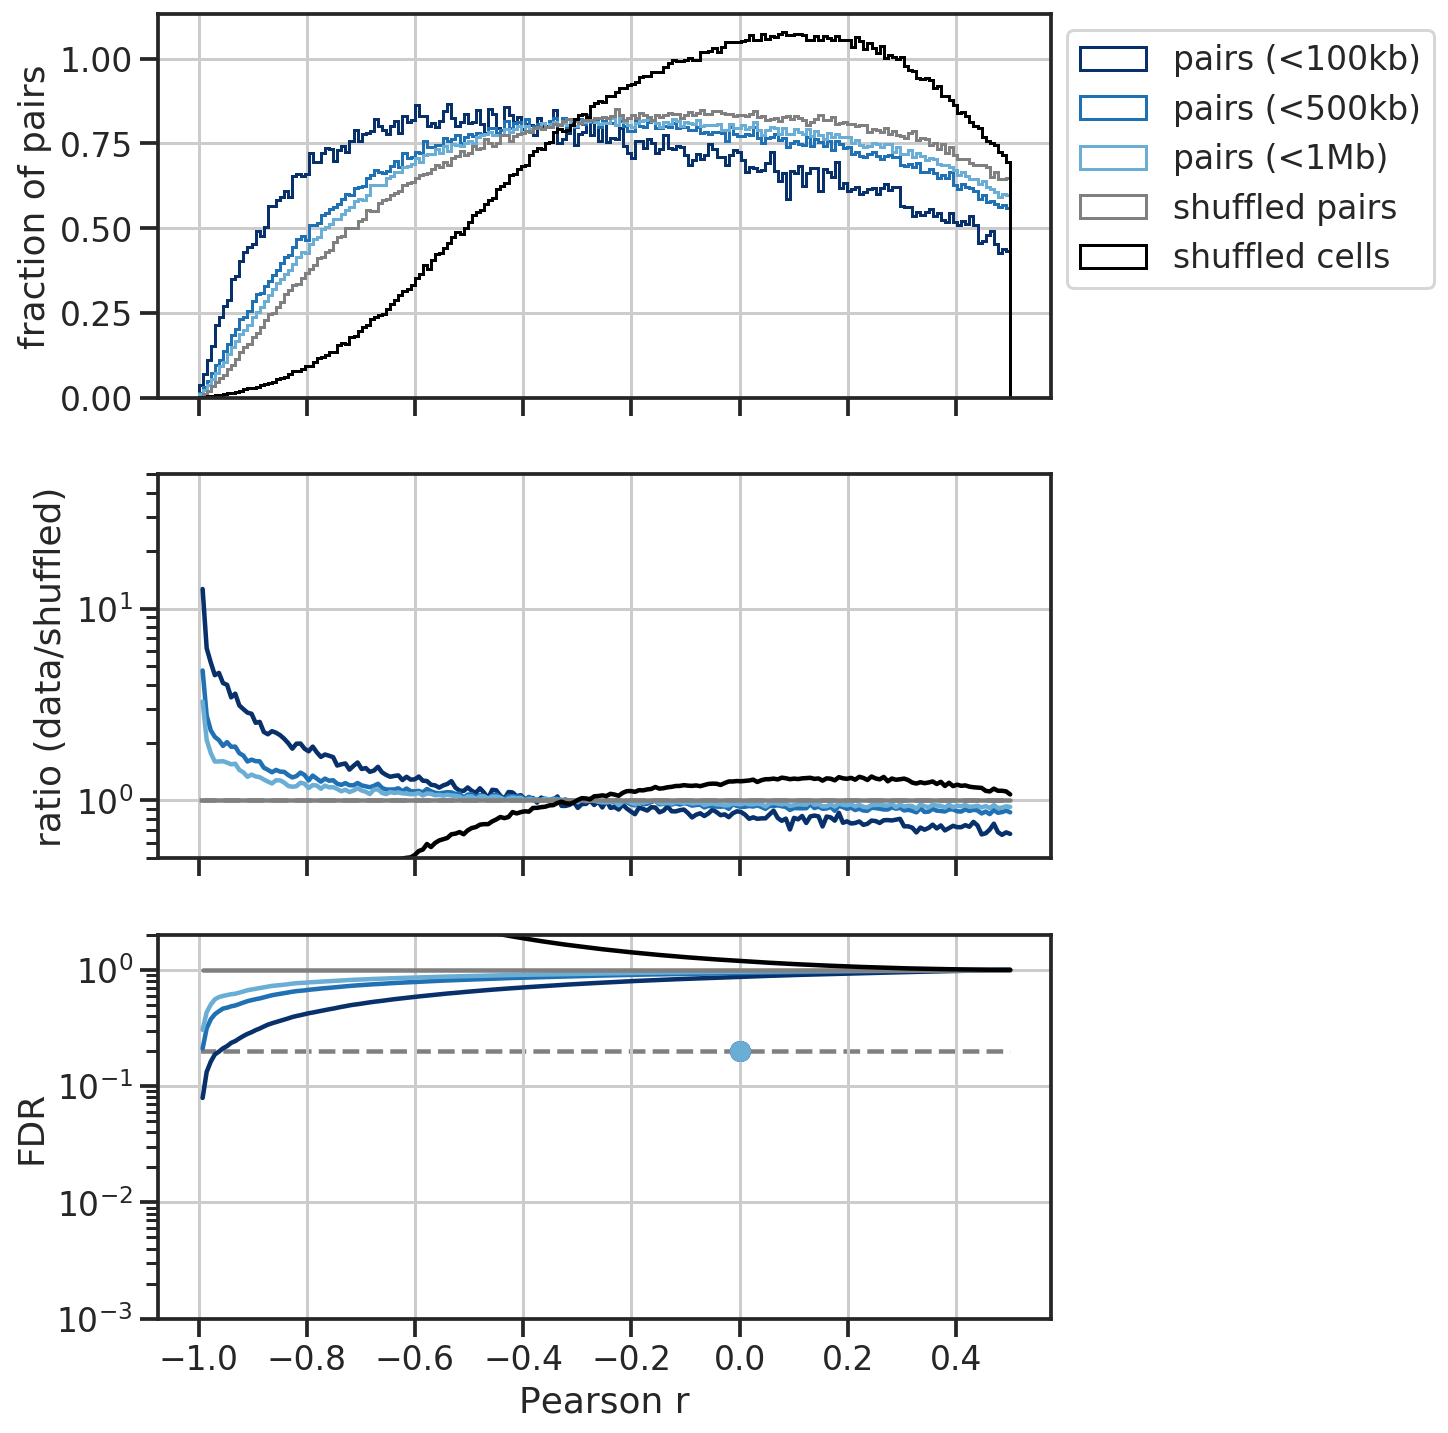

cluster_n9
Number of metacells: 9


11/20/2020 04:42:00 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 9) (233514, 9) (233514, 9)
(172674, 9)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150320 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

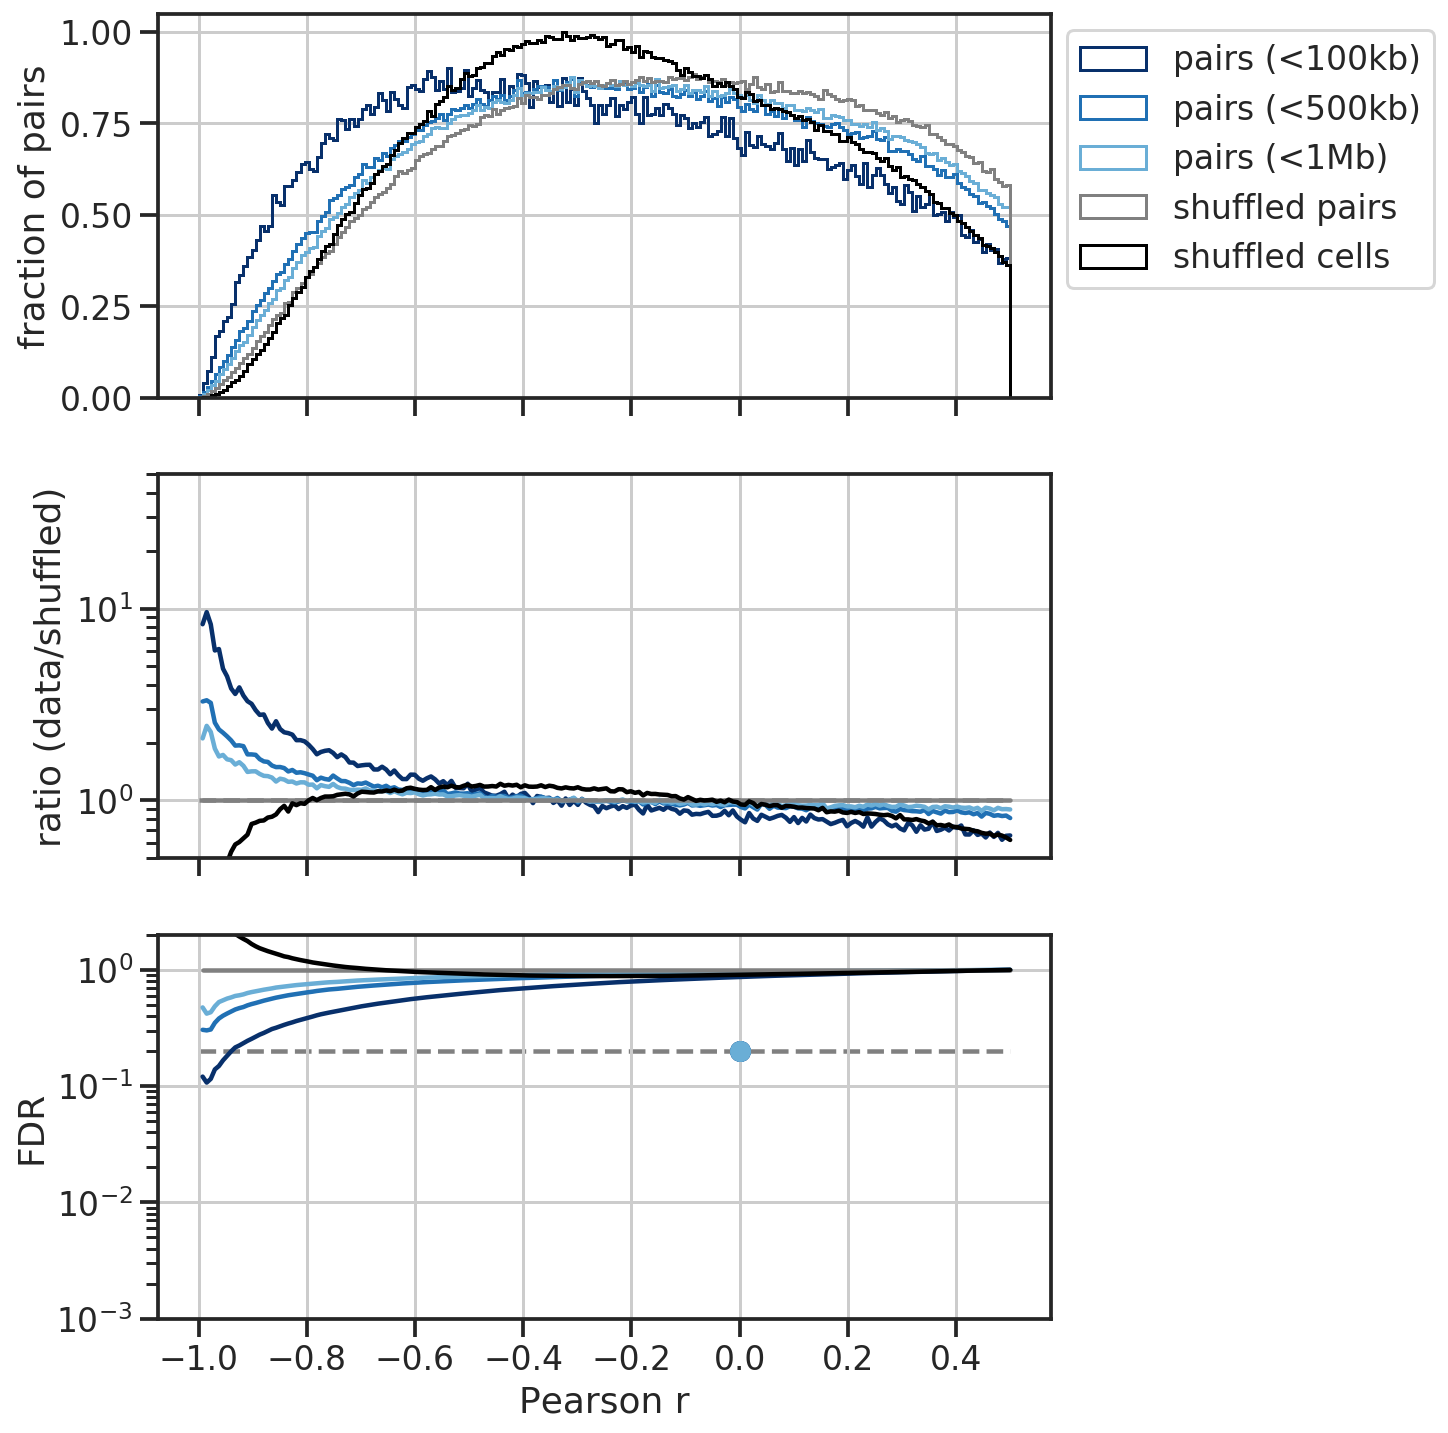

cluster_n12
Number of metacells: 12


11/20/2020 04:42:26 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 12) (233514, 12) (233514, 12)
(173776, 12)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150494 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

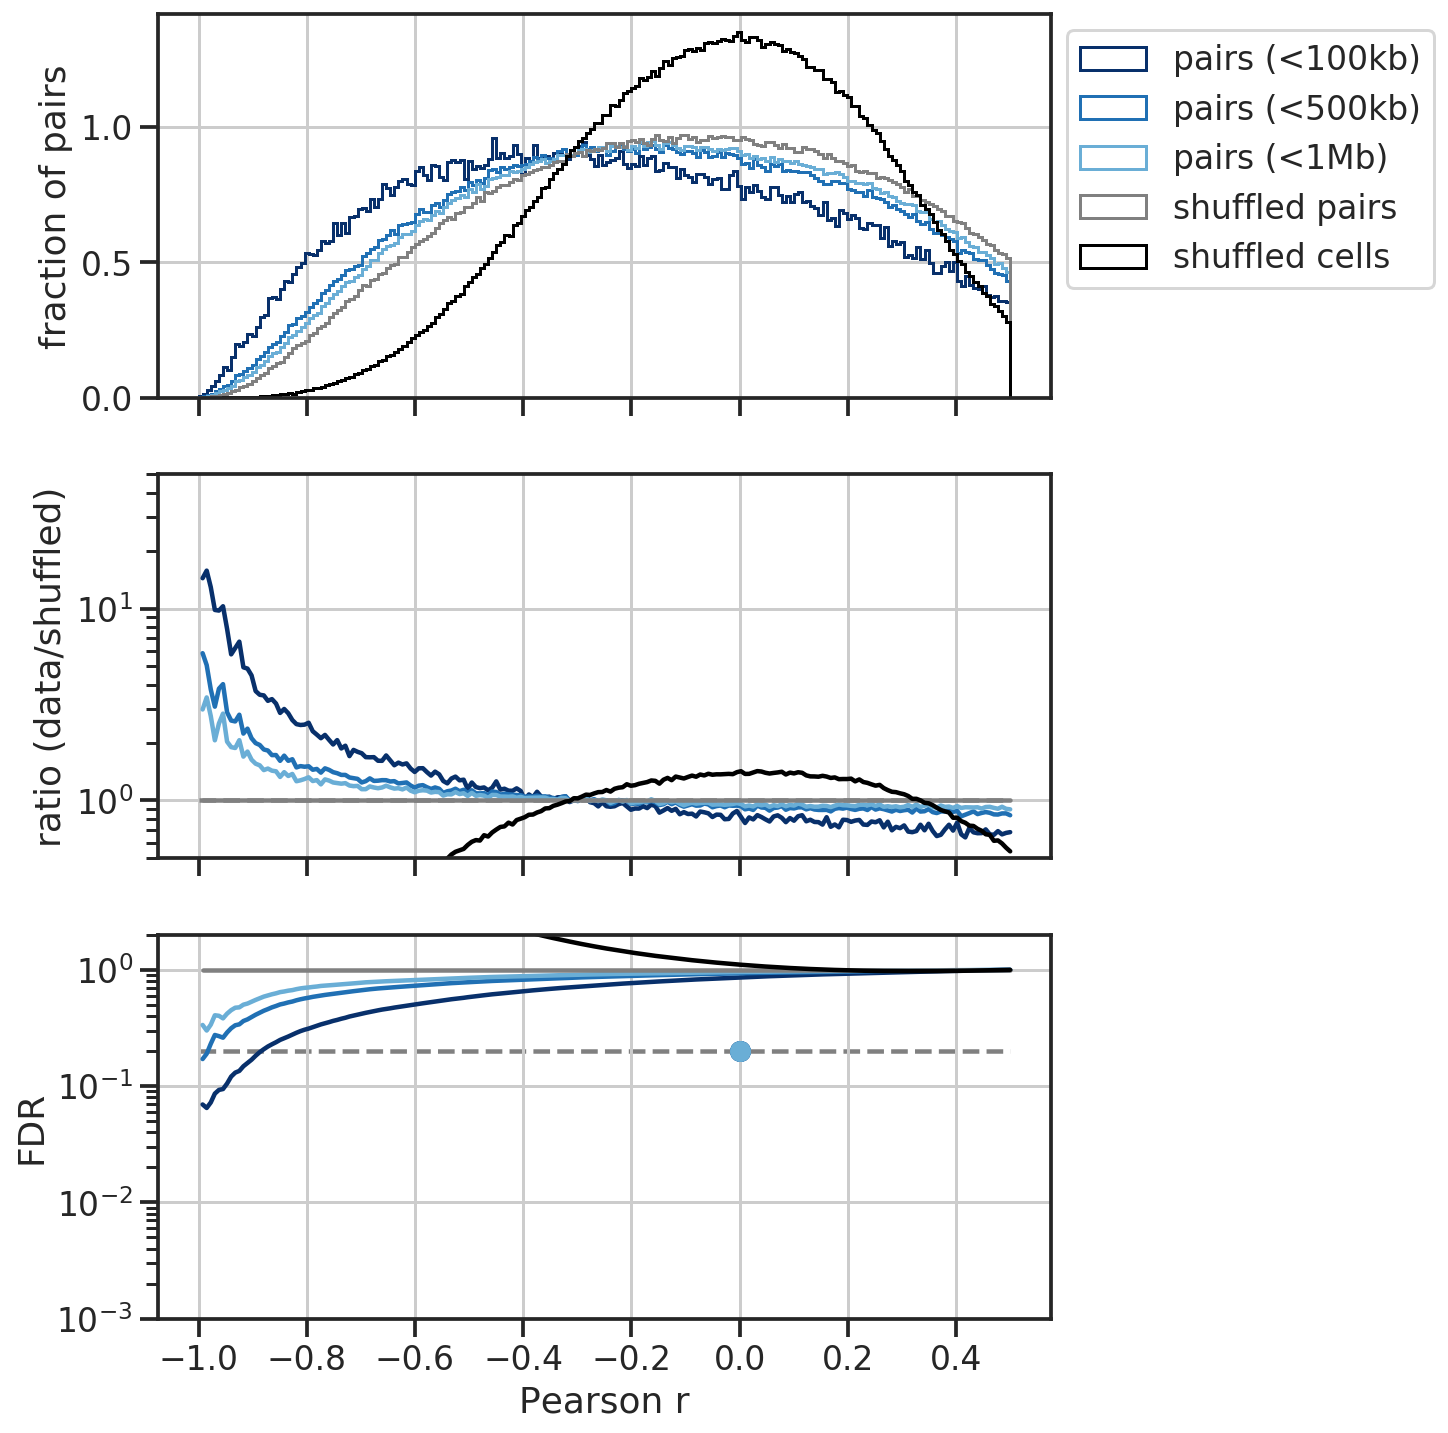

cluster_n13
Number of metacells: 13


11/20/2020 04:42:54 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 13) (233514, 13) (233514, 13)
(172345, 13)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150278 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

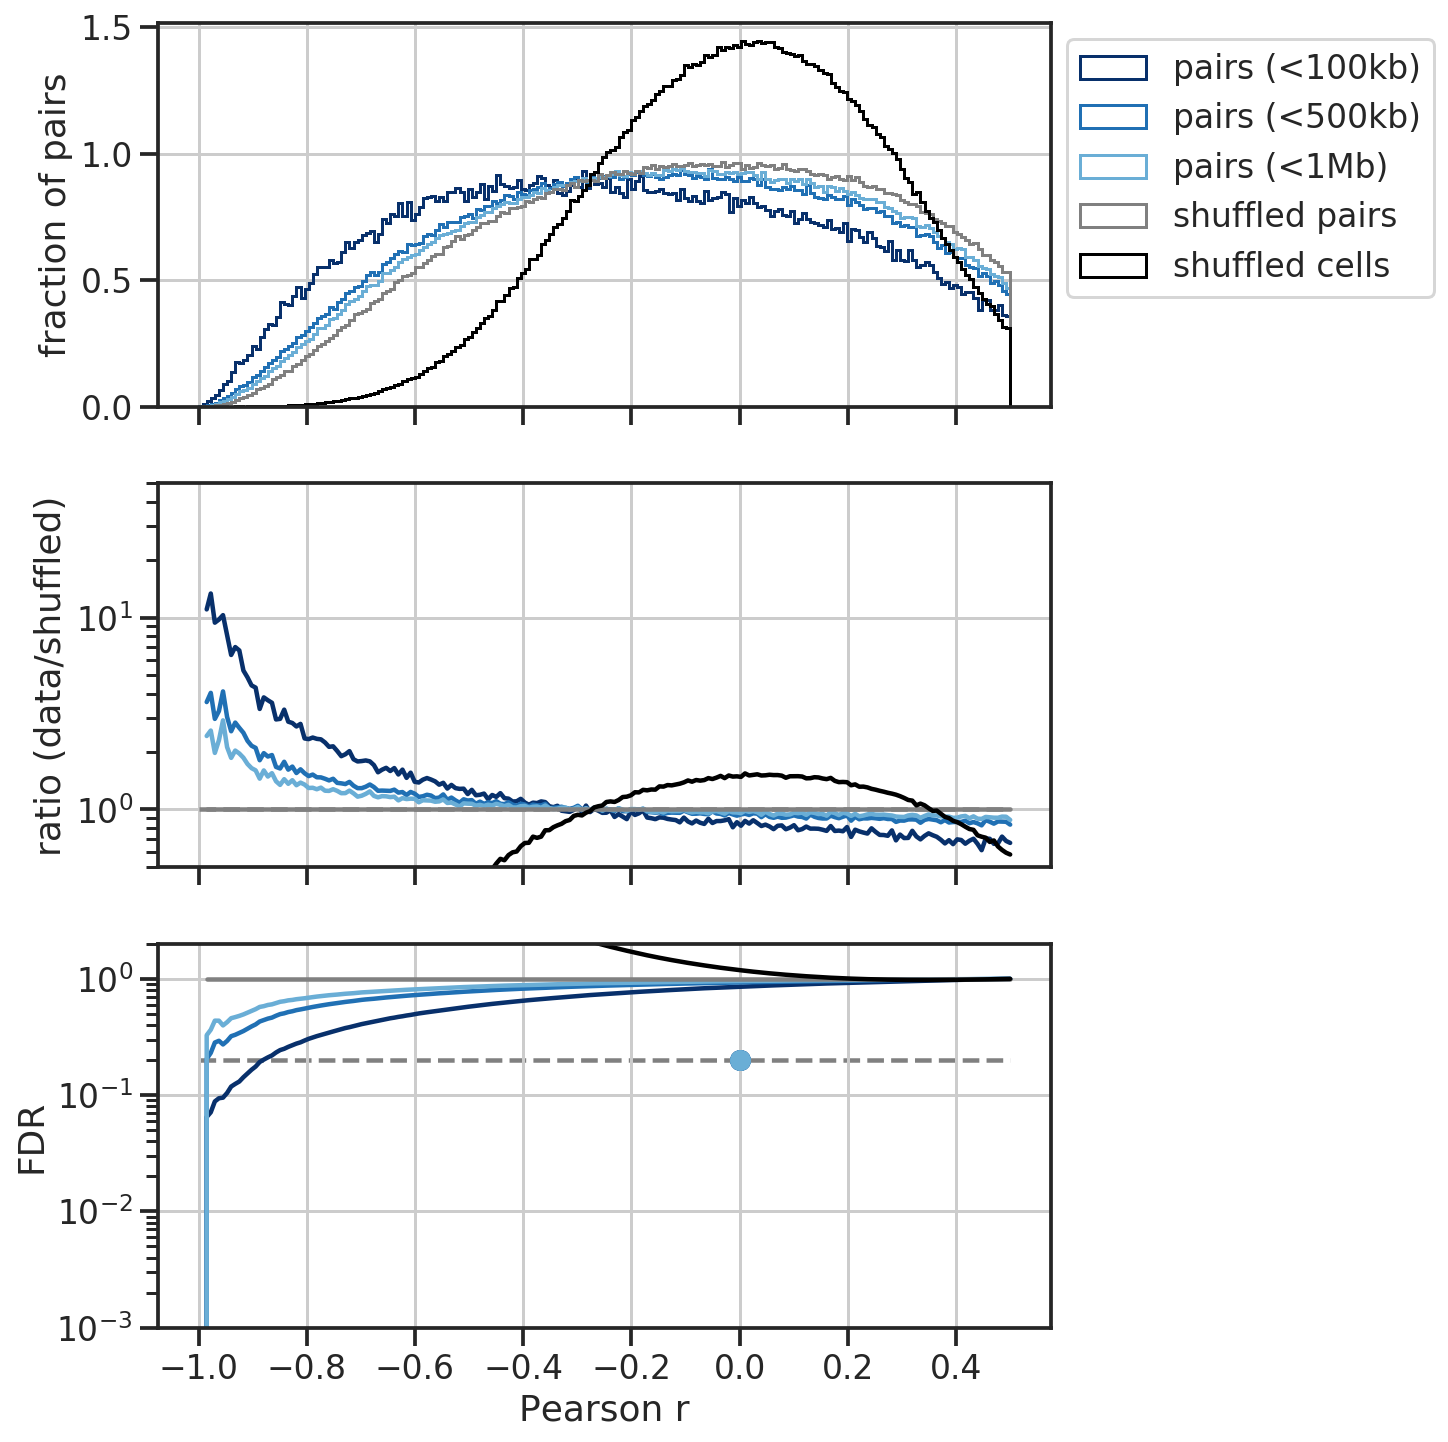

cluster_n14
Number of metacells: 14


11/20/2020 04:43:26 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 14) (233514, 14) (233514, 14)
(171925, 14)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150232 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

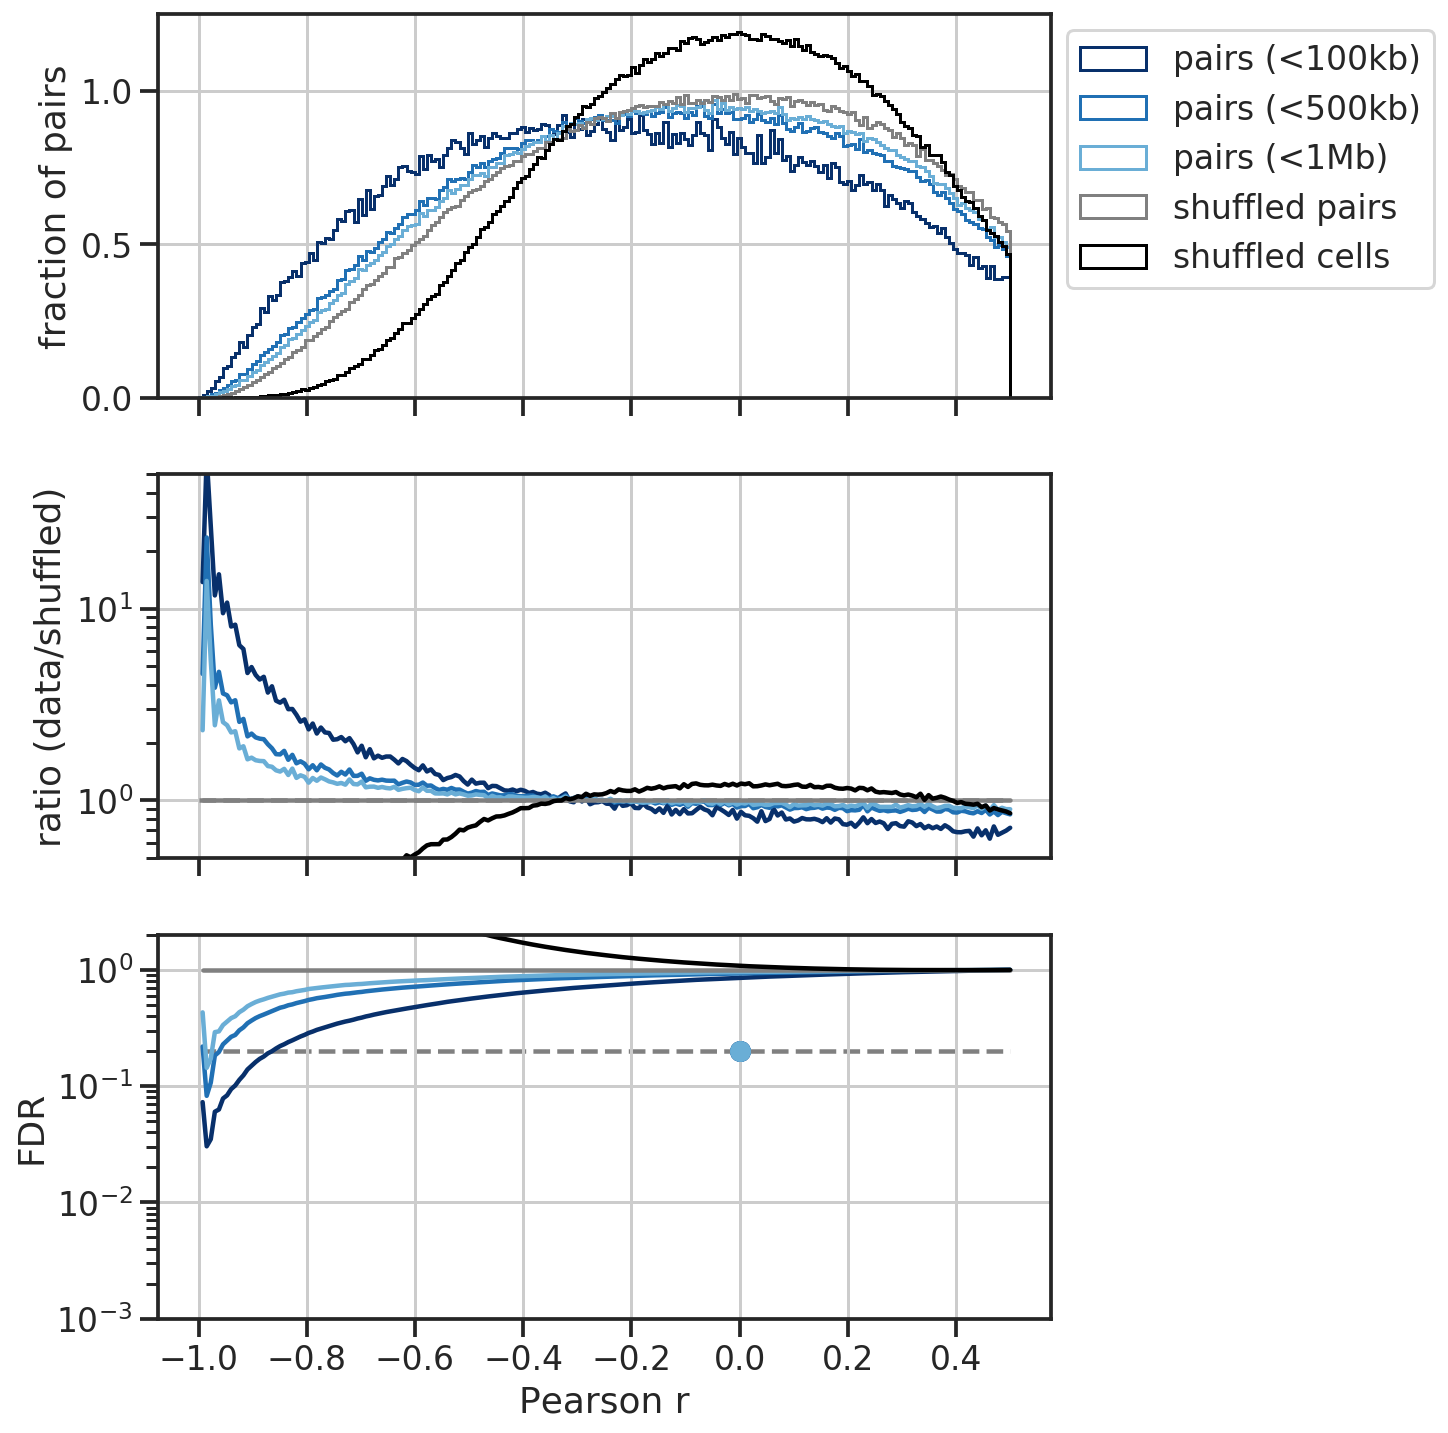

cluster_n16
Number of metacells: 16


11/20/2020 04:43:56 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 16) (233514, 16) (233514, 16)
(174055, 16)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150528 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

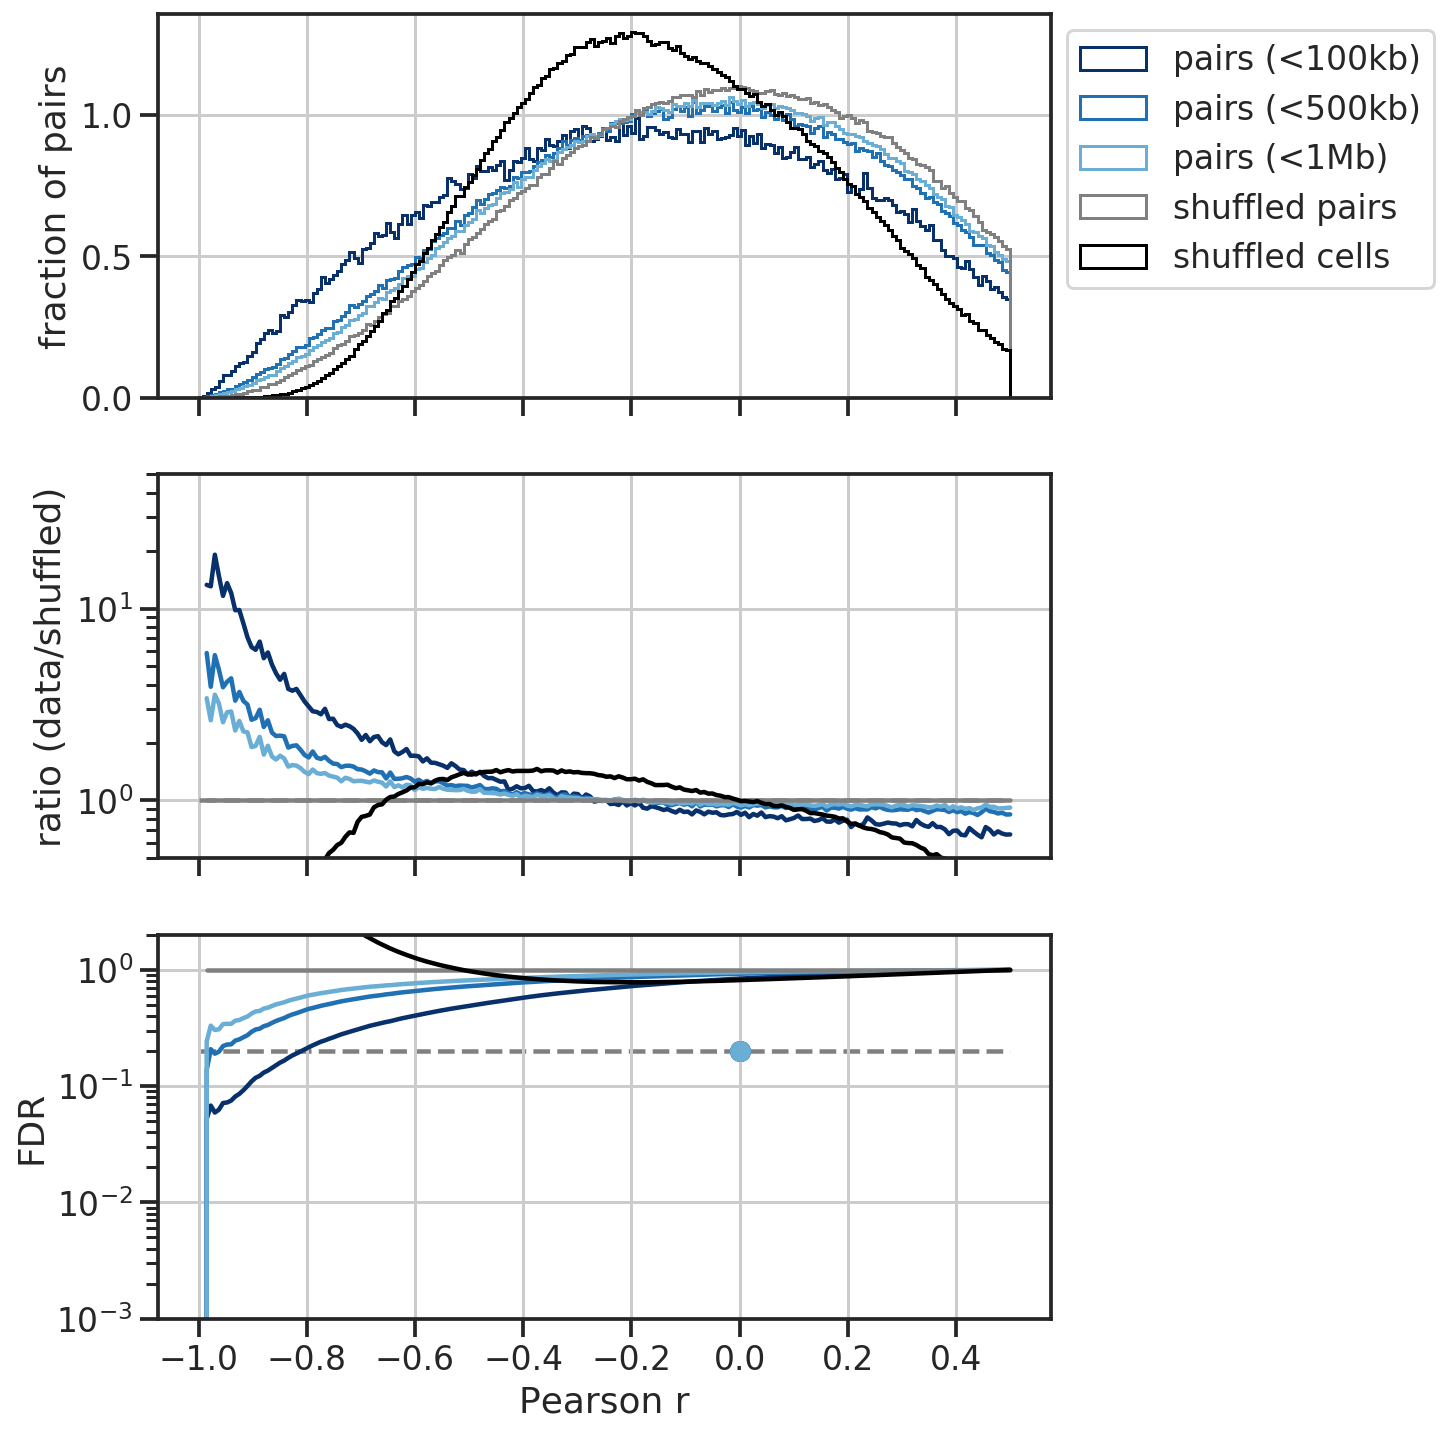

cluster_n17
Number of metacells: 17


11/20/2020 04:44:28 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 17) (233514, 17) (233514, 17)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(173343, 17)
2062 1000000
150438 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

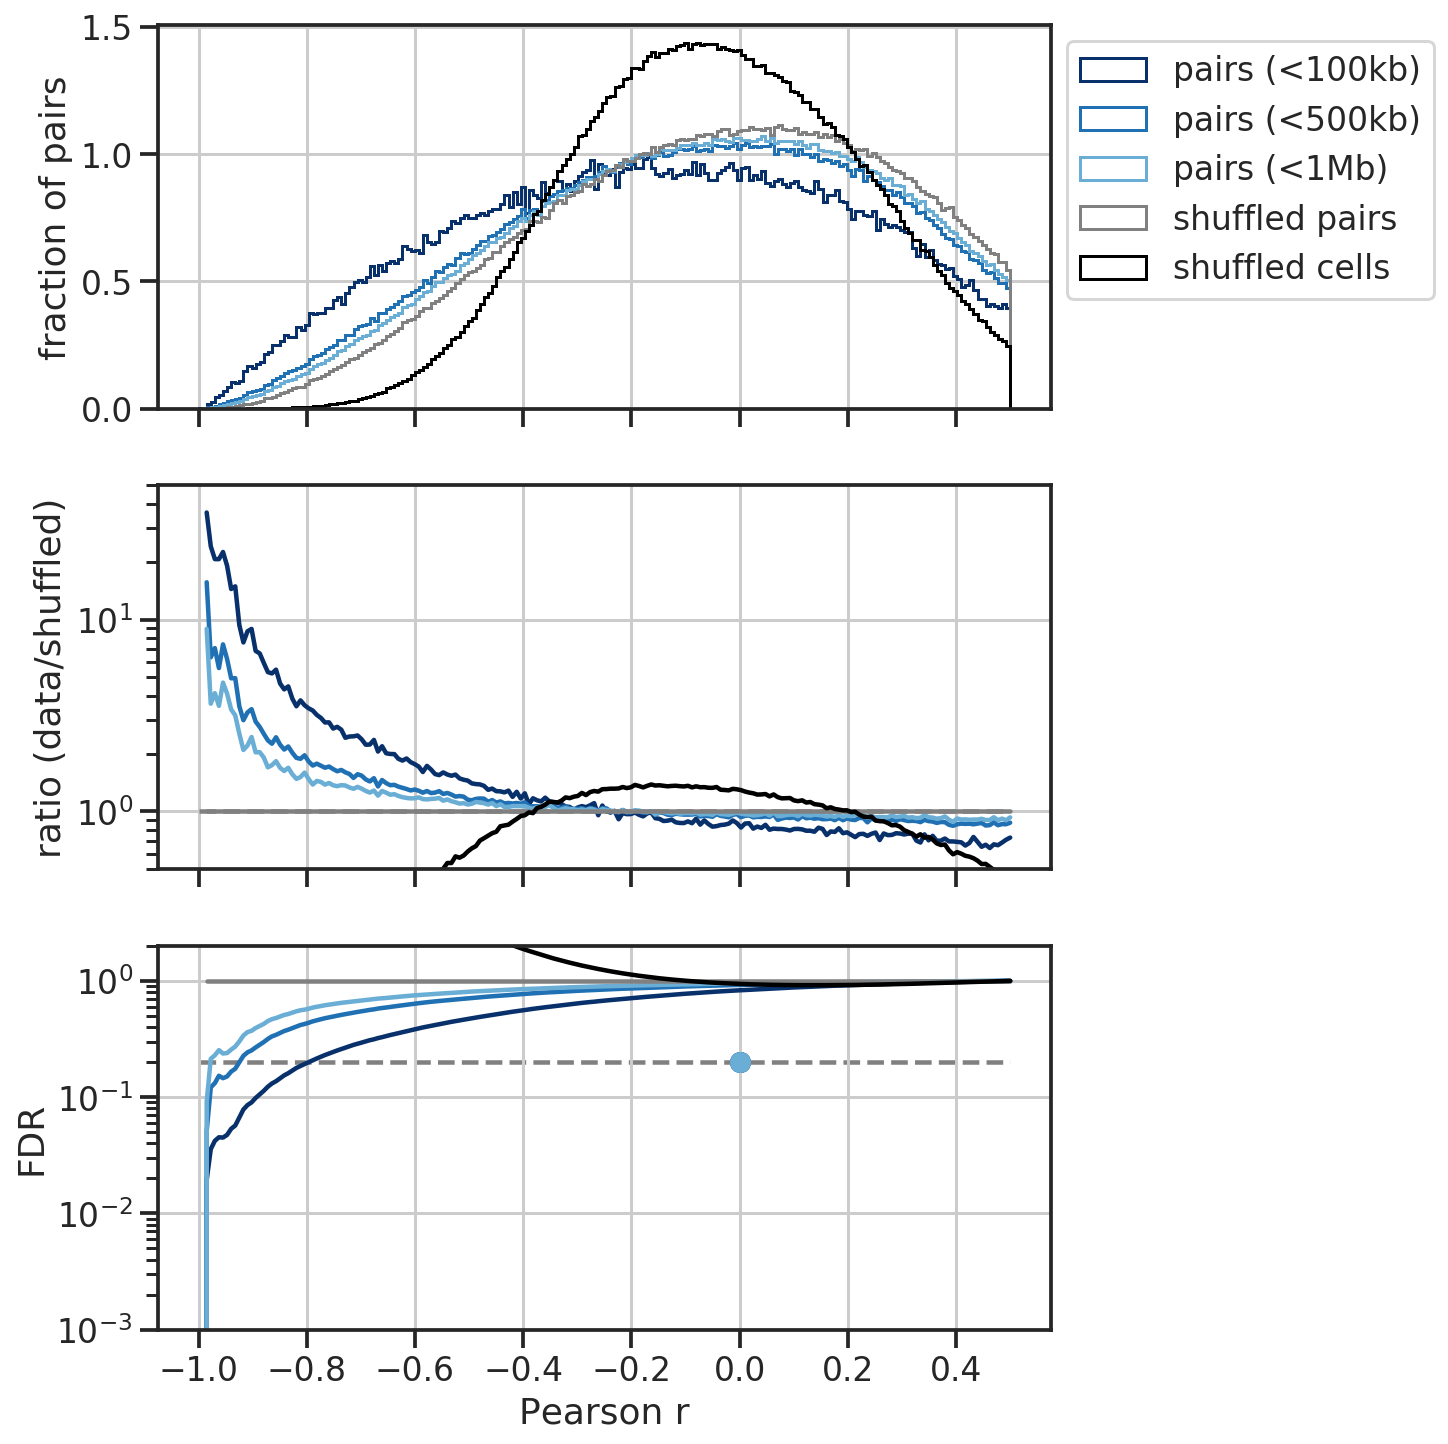

cluster_n20
Number of metacells: 20


11/20/2020 04:45:02 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(31053, 20) (233514, 20) (233514, 20)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(173530, 20)
2062 1000000
150486 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

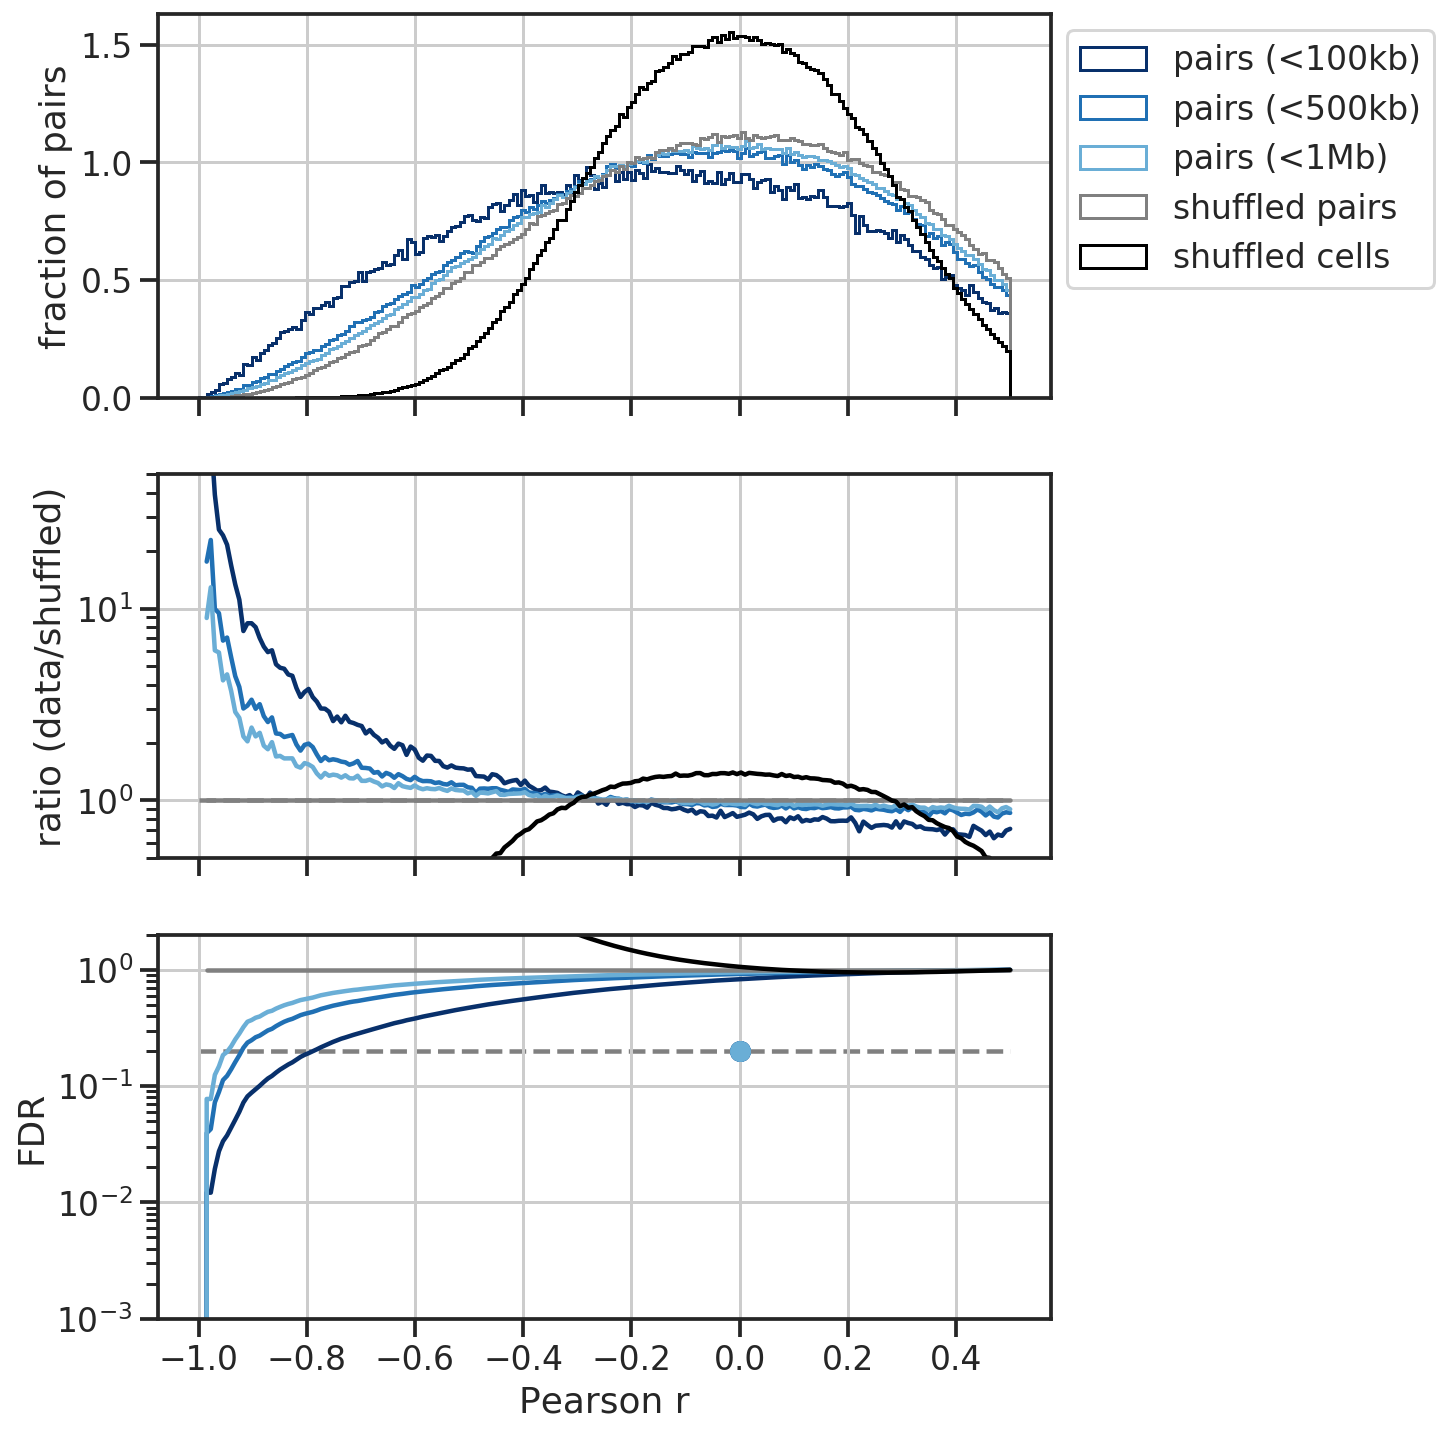

cluster_n24
Number of metacells: 24
(31053, 24) (233514, 24) (233514, 24)


11/20/2020 04:45:36 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(172765, 24)
2062 1000000
150406 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

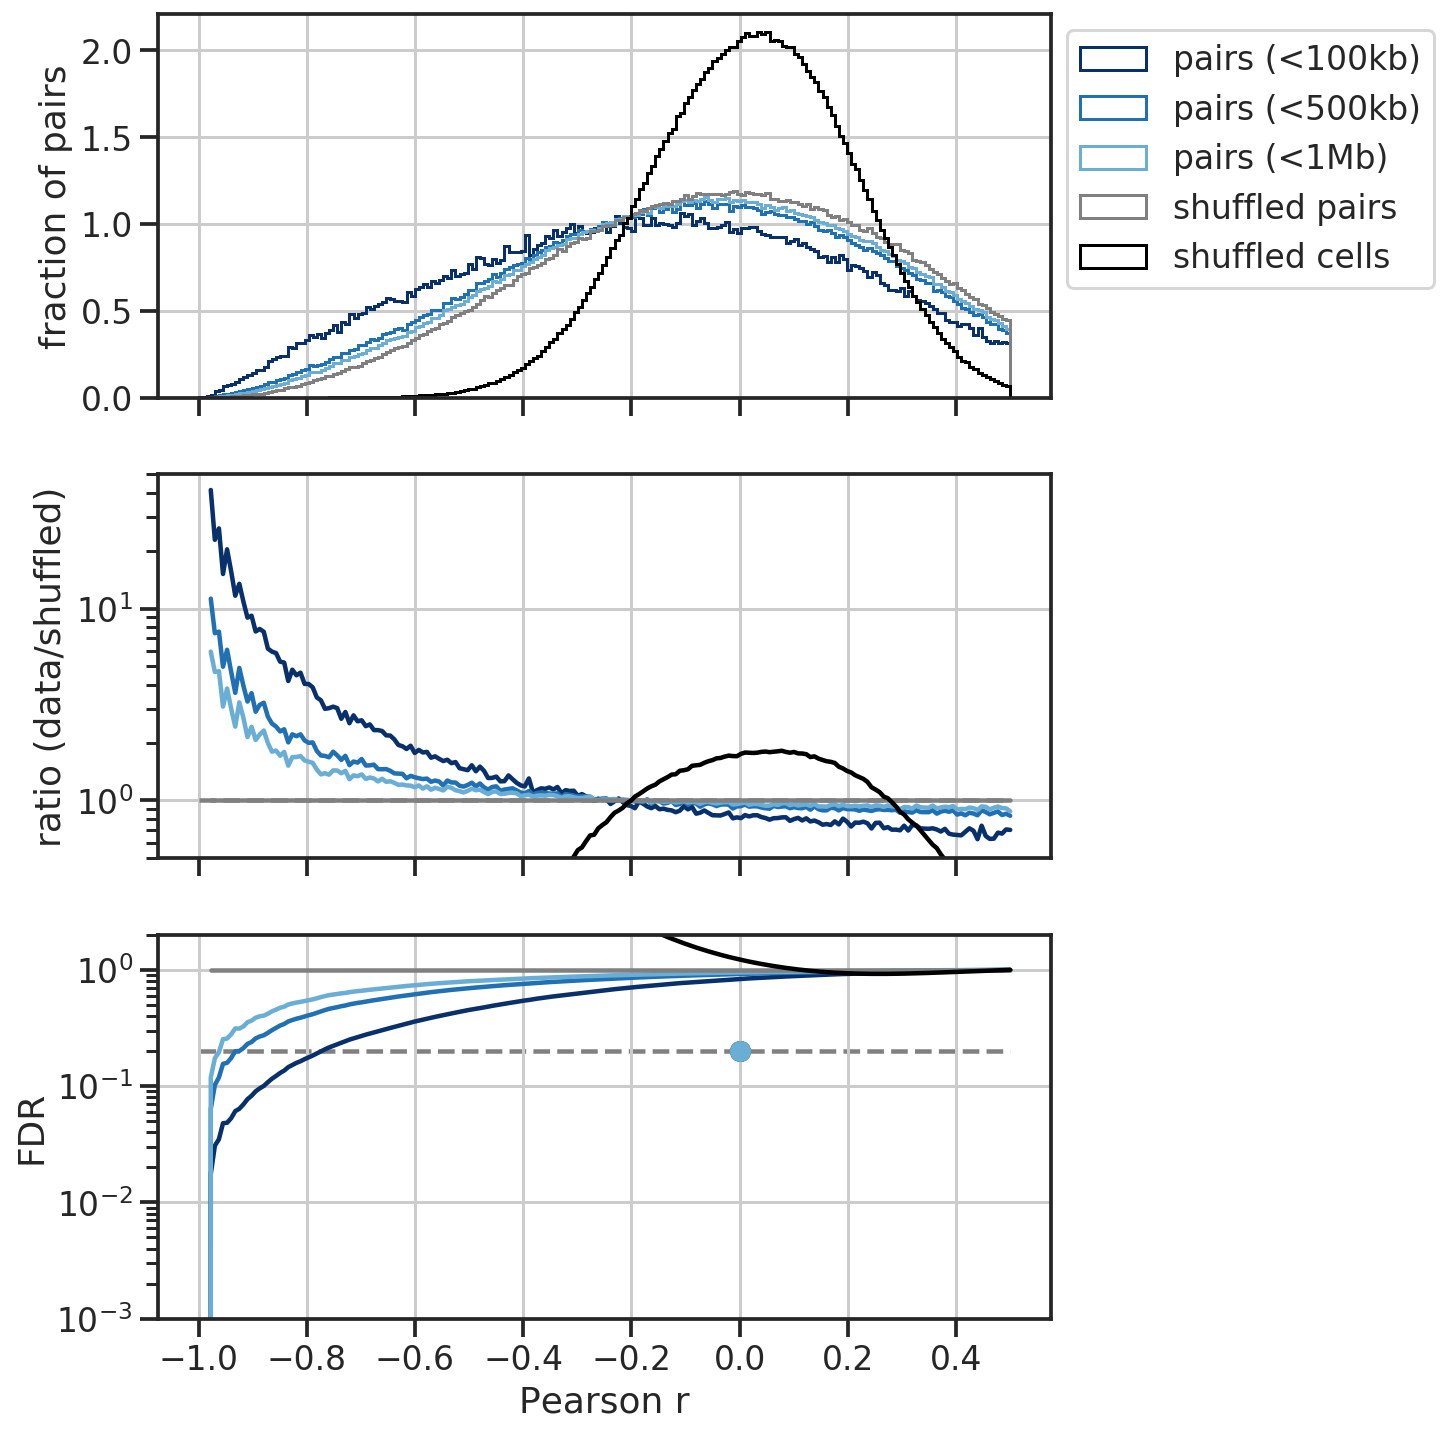

cluster_n29
Number of metacells: 29
(31053, 29) (233514, 29) (233514, 29)


11/20/2020 04:46:15 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(172958, 29)
2062 1000000
150461 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

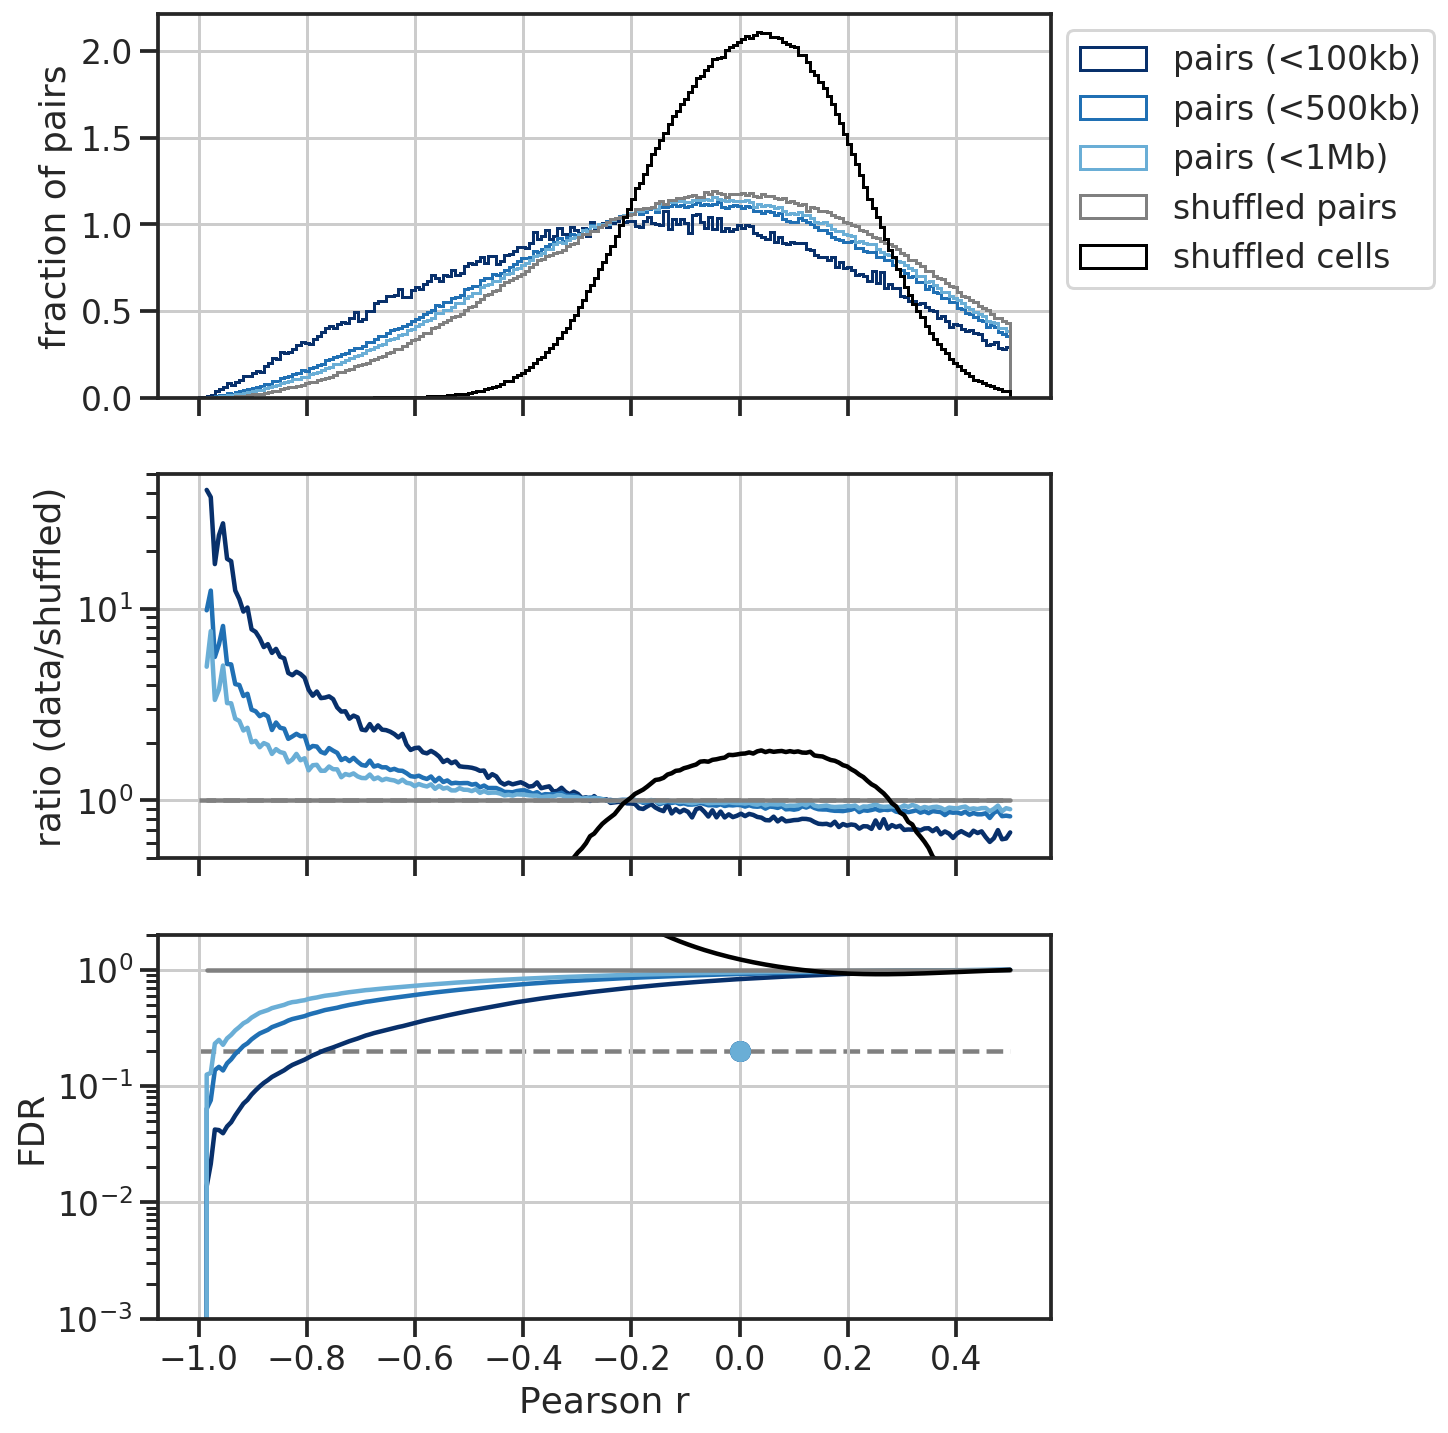

cluster_n34
Number of metacells: 34
(31053, 34) (233514, 34) (233514, 34)


11/20/2020 04:47:00 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(173238, 34)
2062 1000000
150485 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

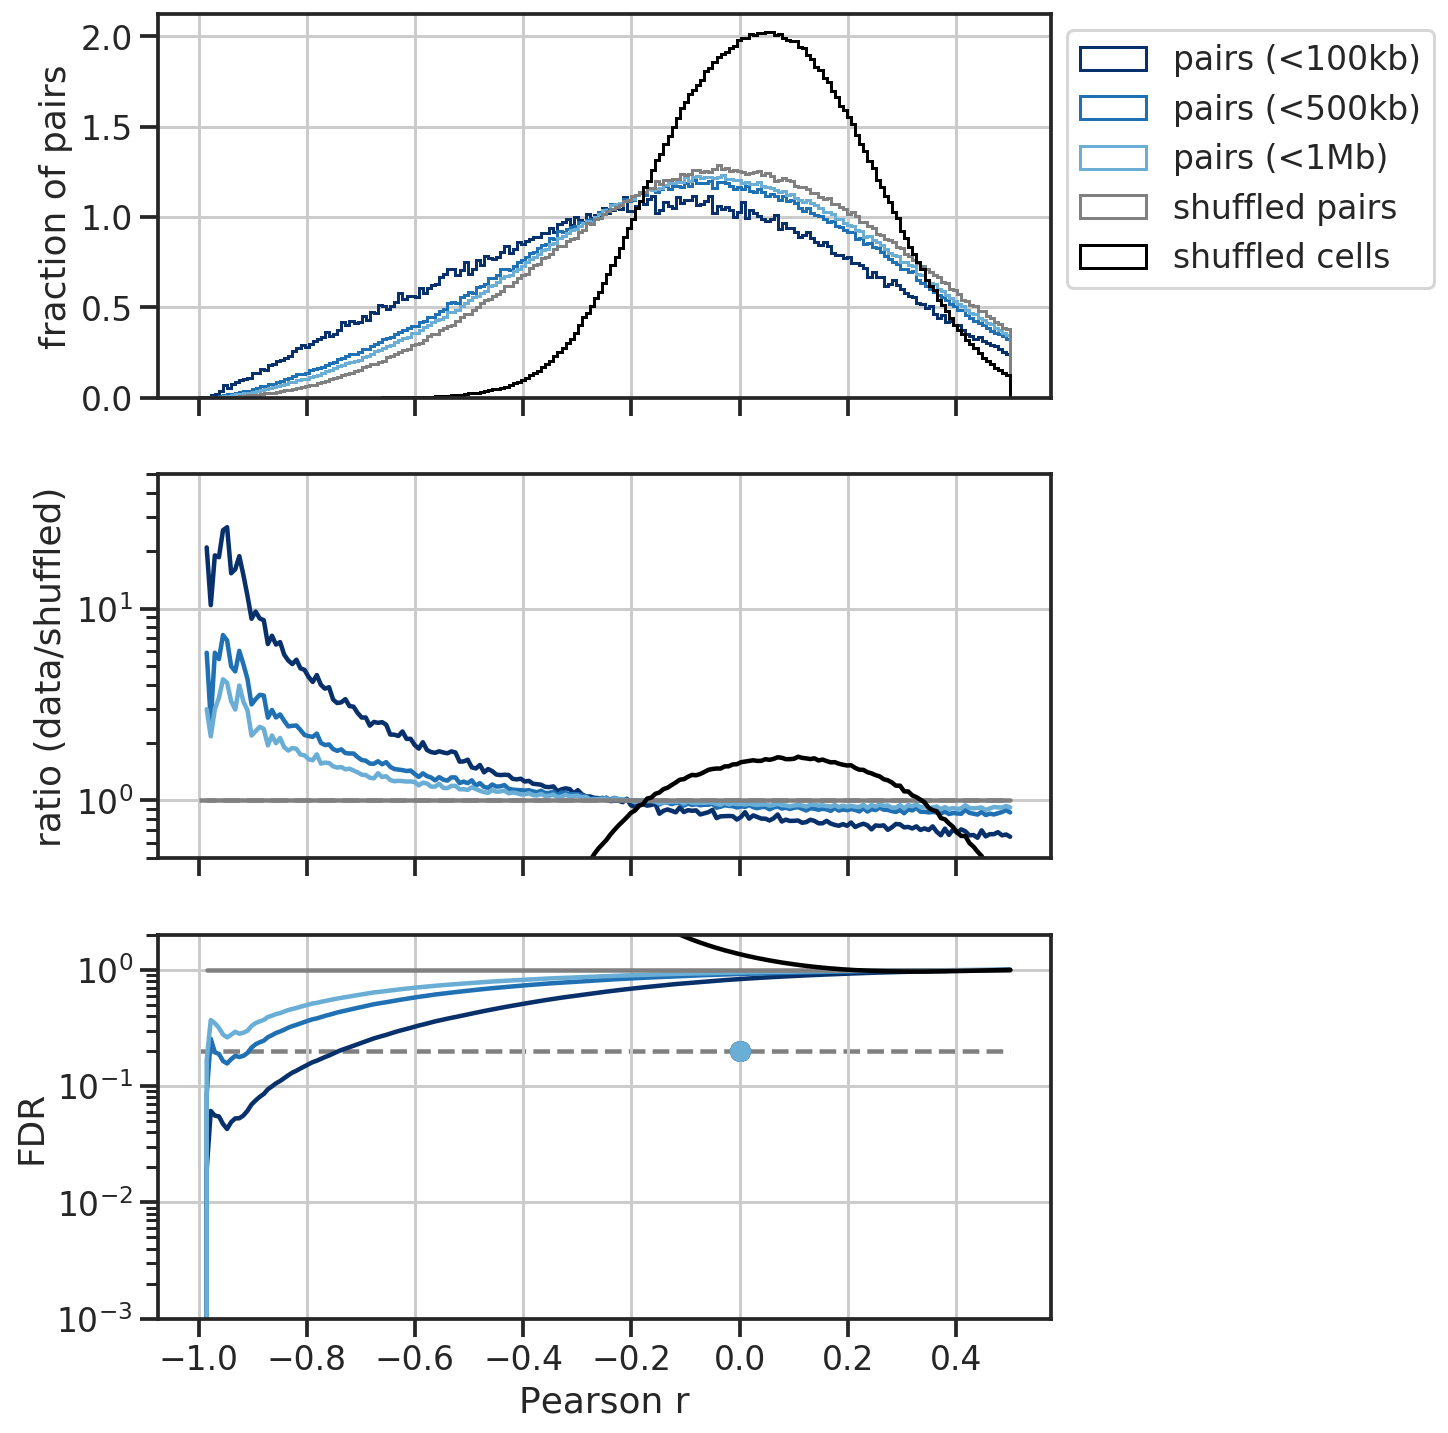

cluster_n40
Number of metacells: 40
(31053, 40) (233514, 40) (233514, 40)


11/20/2020 04:47:47 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(174167, 40)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150567 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

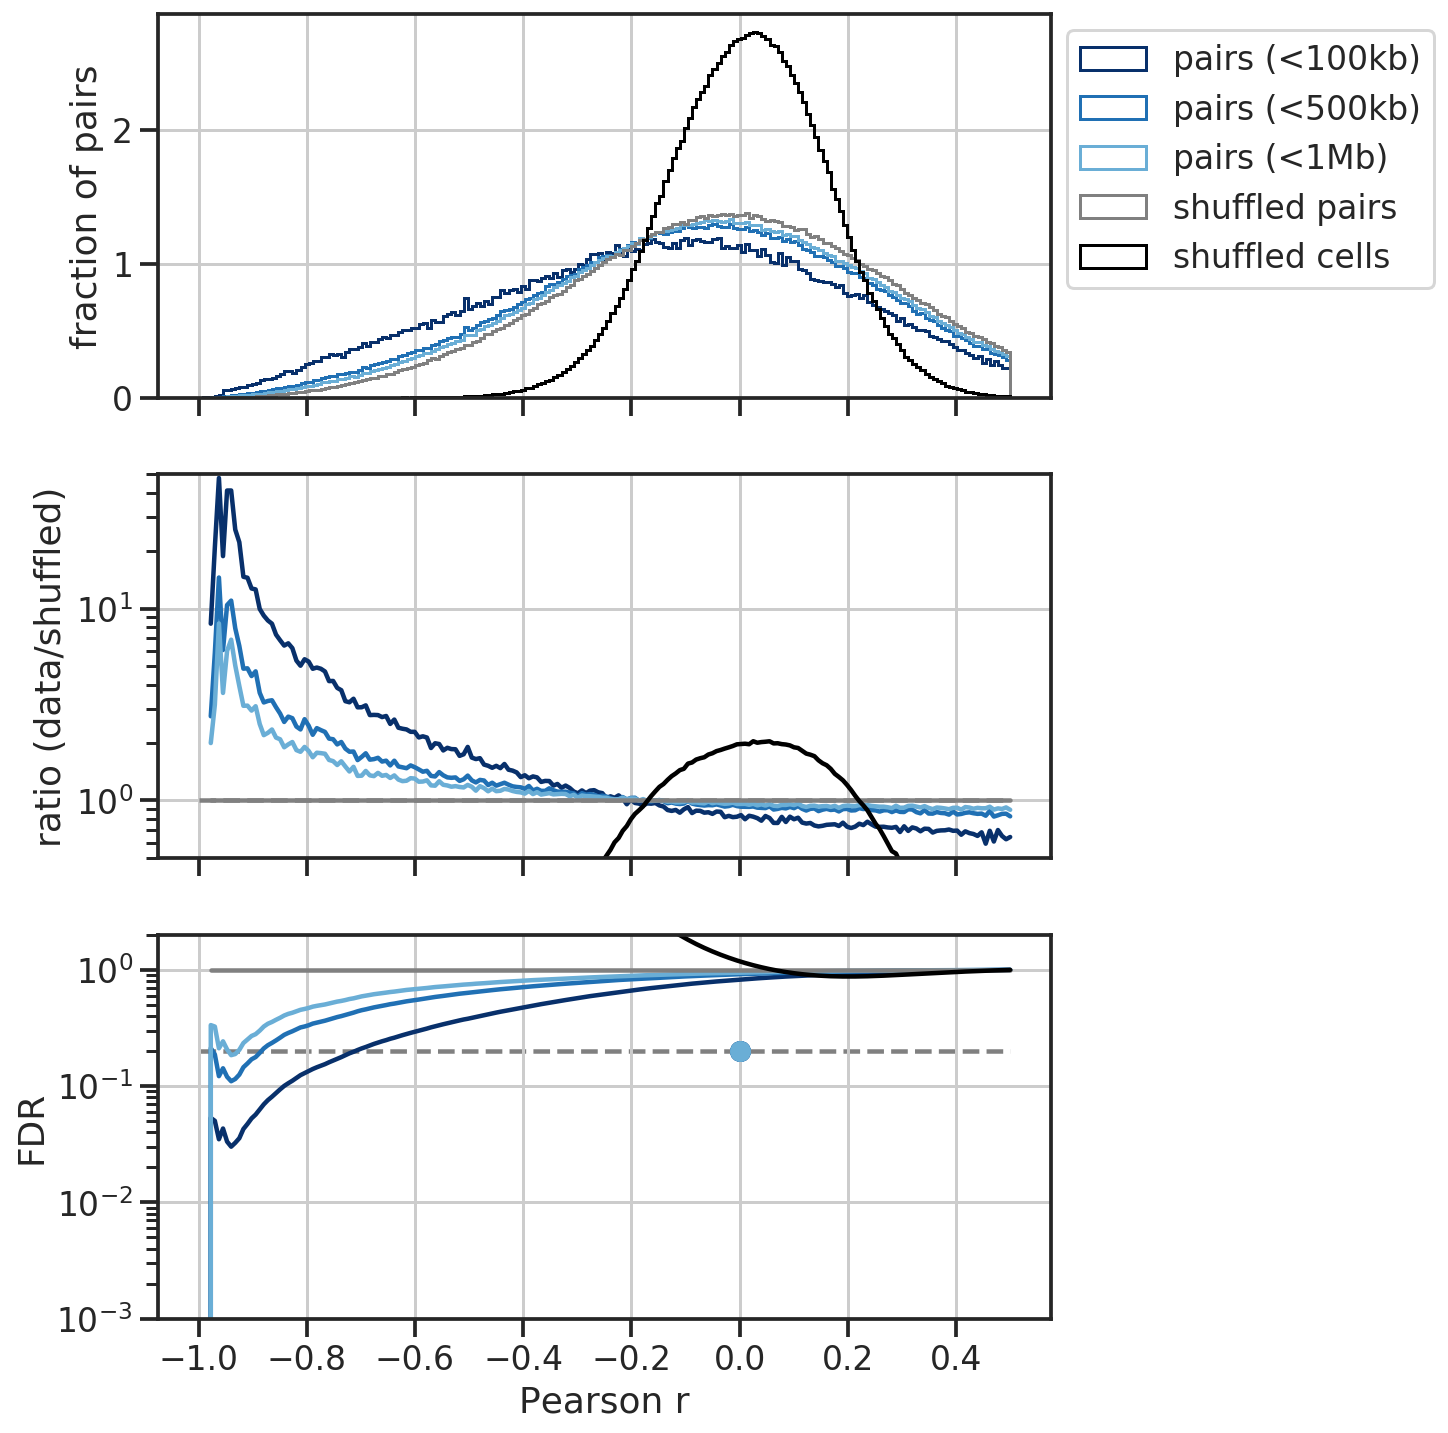

cluster_n51
Number of metacells: 51
(31053, 51) (233514, 51) (233514, 51)


11/20/2020 04:48:34 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(173558, 51)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150509 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

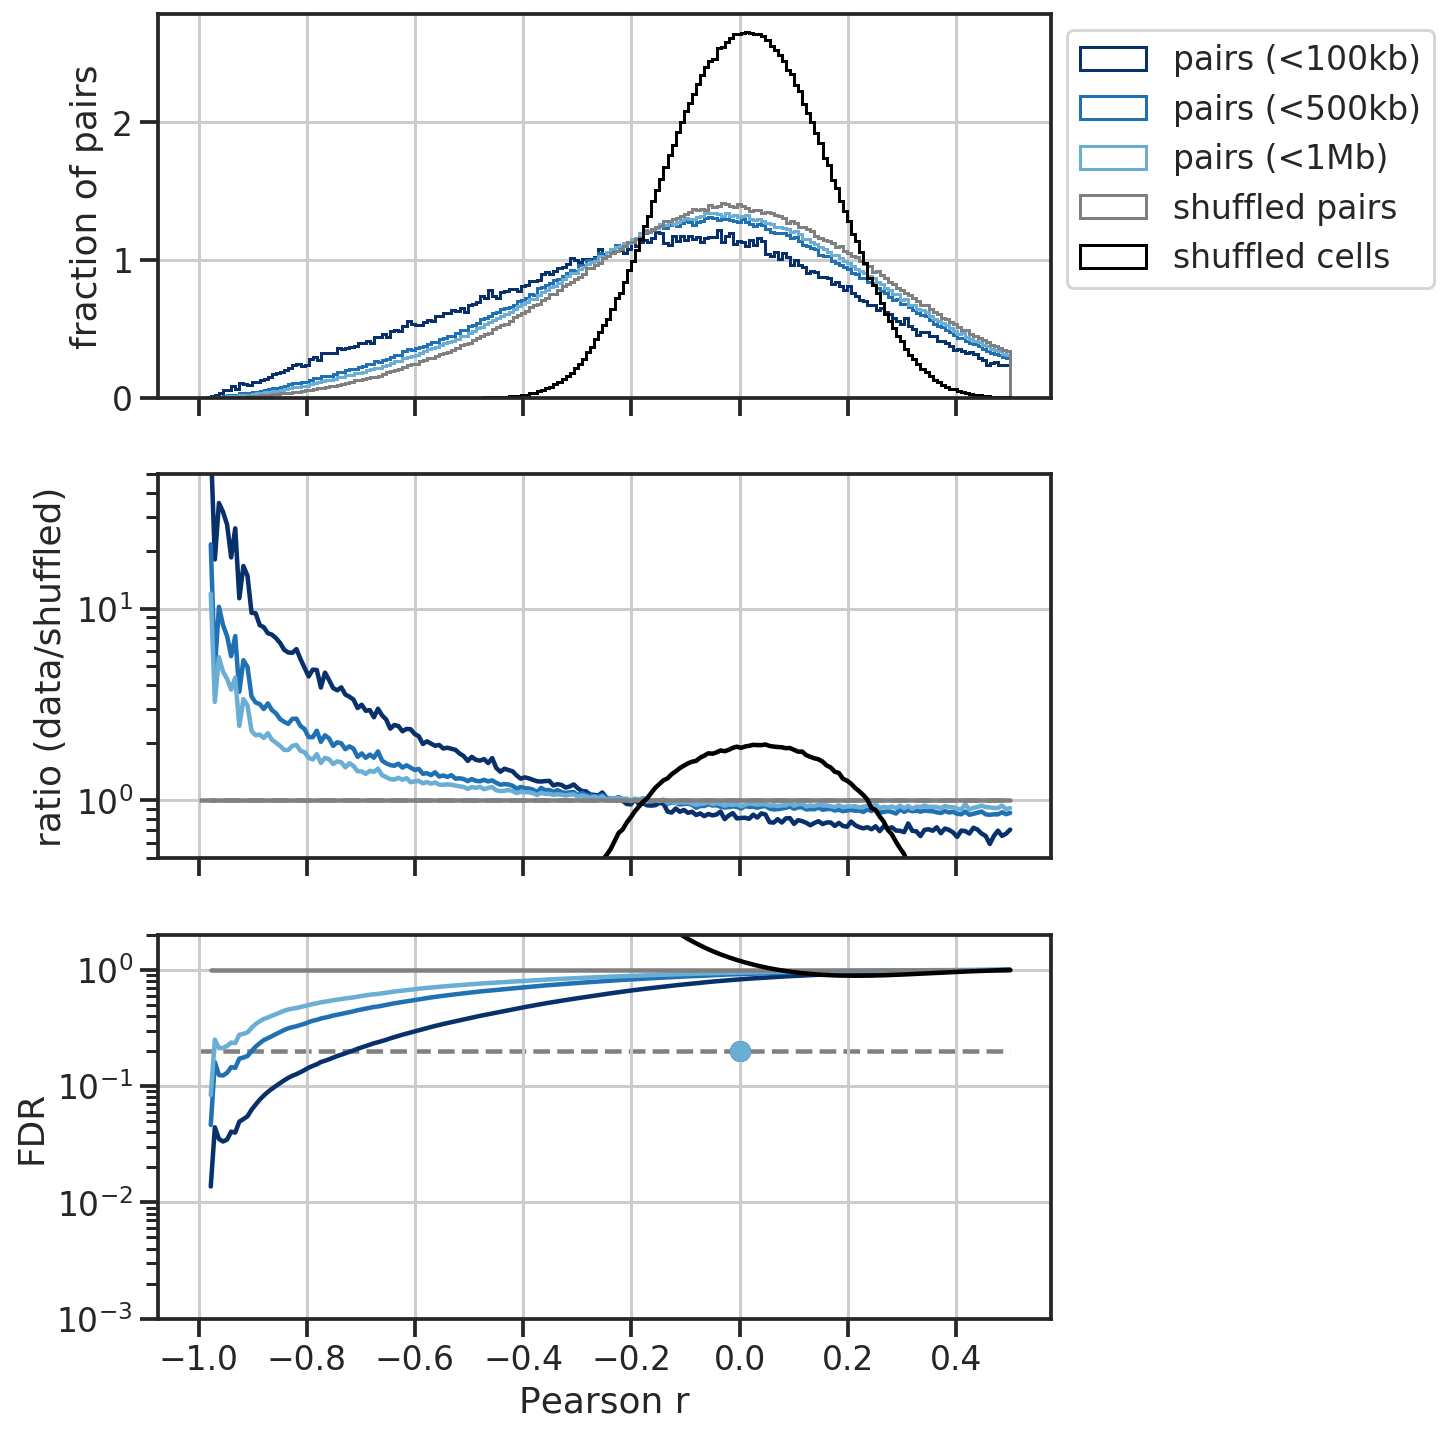

cluster_n63
Number of metacells: 63
(31053, 63) (233514, 63) (233514, 63)


11/20/2020 04:49:27 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(173187, 63)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150470 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

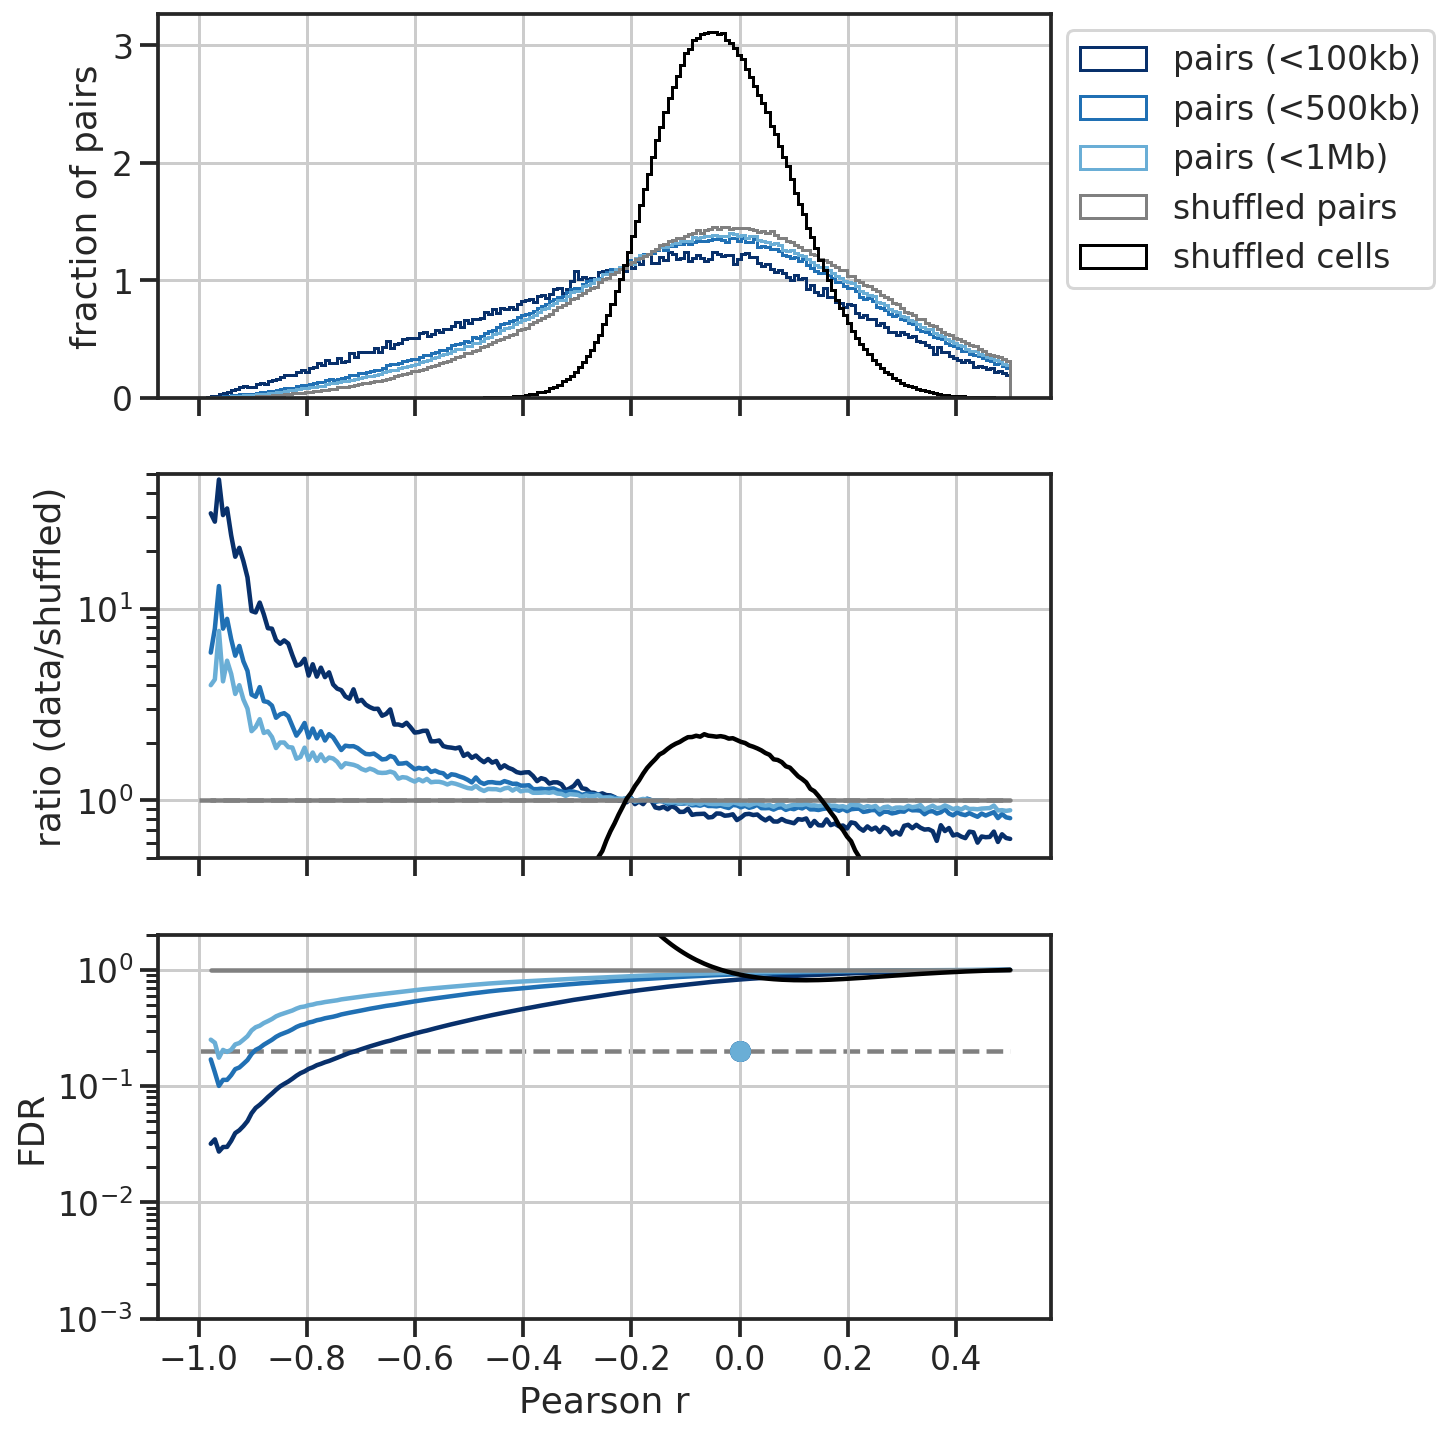

cluster_n75
Number of metacells: 75
(31053, 75) (233514, 75) (233514, 75)


11/20/2020 04:50:31 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(173423, 75)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150504 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

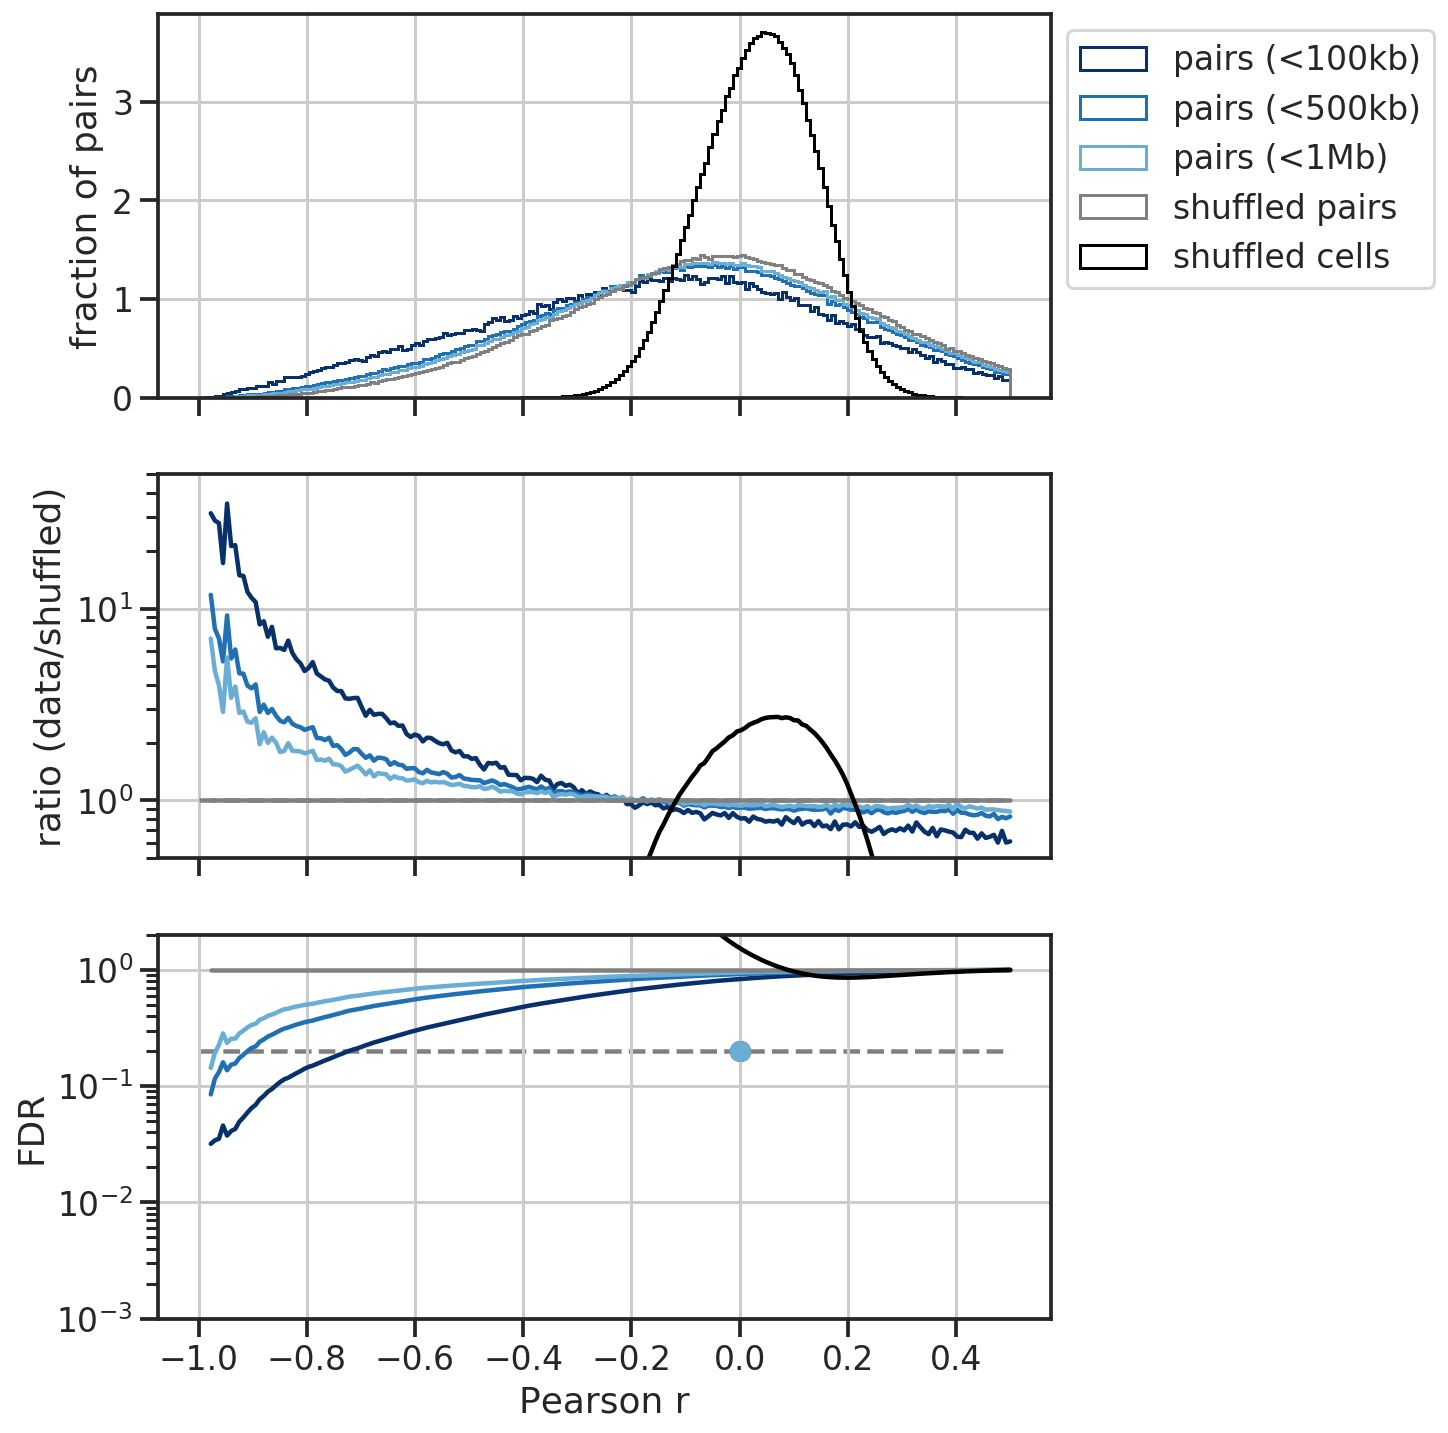

cluster_n88
Number of metacells: 88
(31053, 88) (233514, 88) (233514, 88)


11/20/2020 04:51:33 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(173004, 88)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150455 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

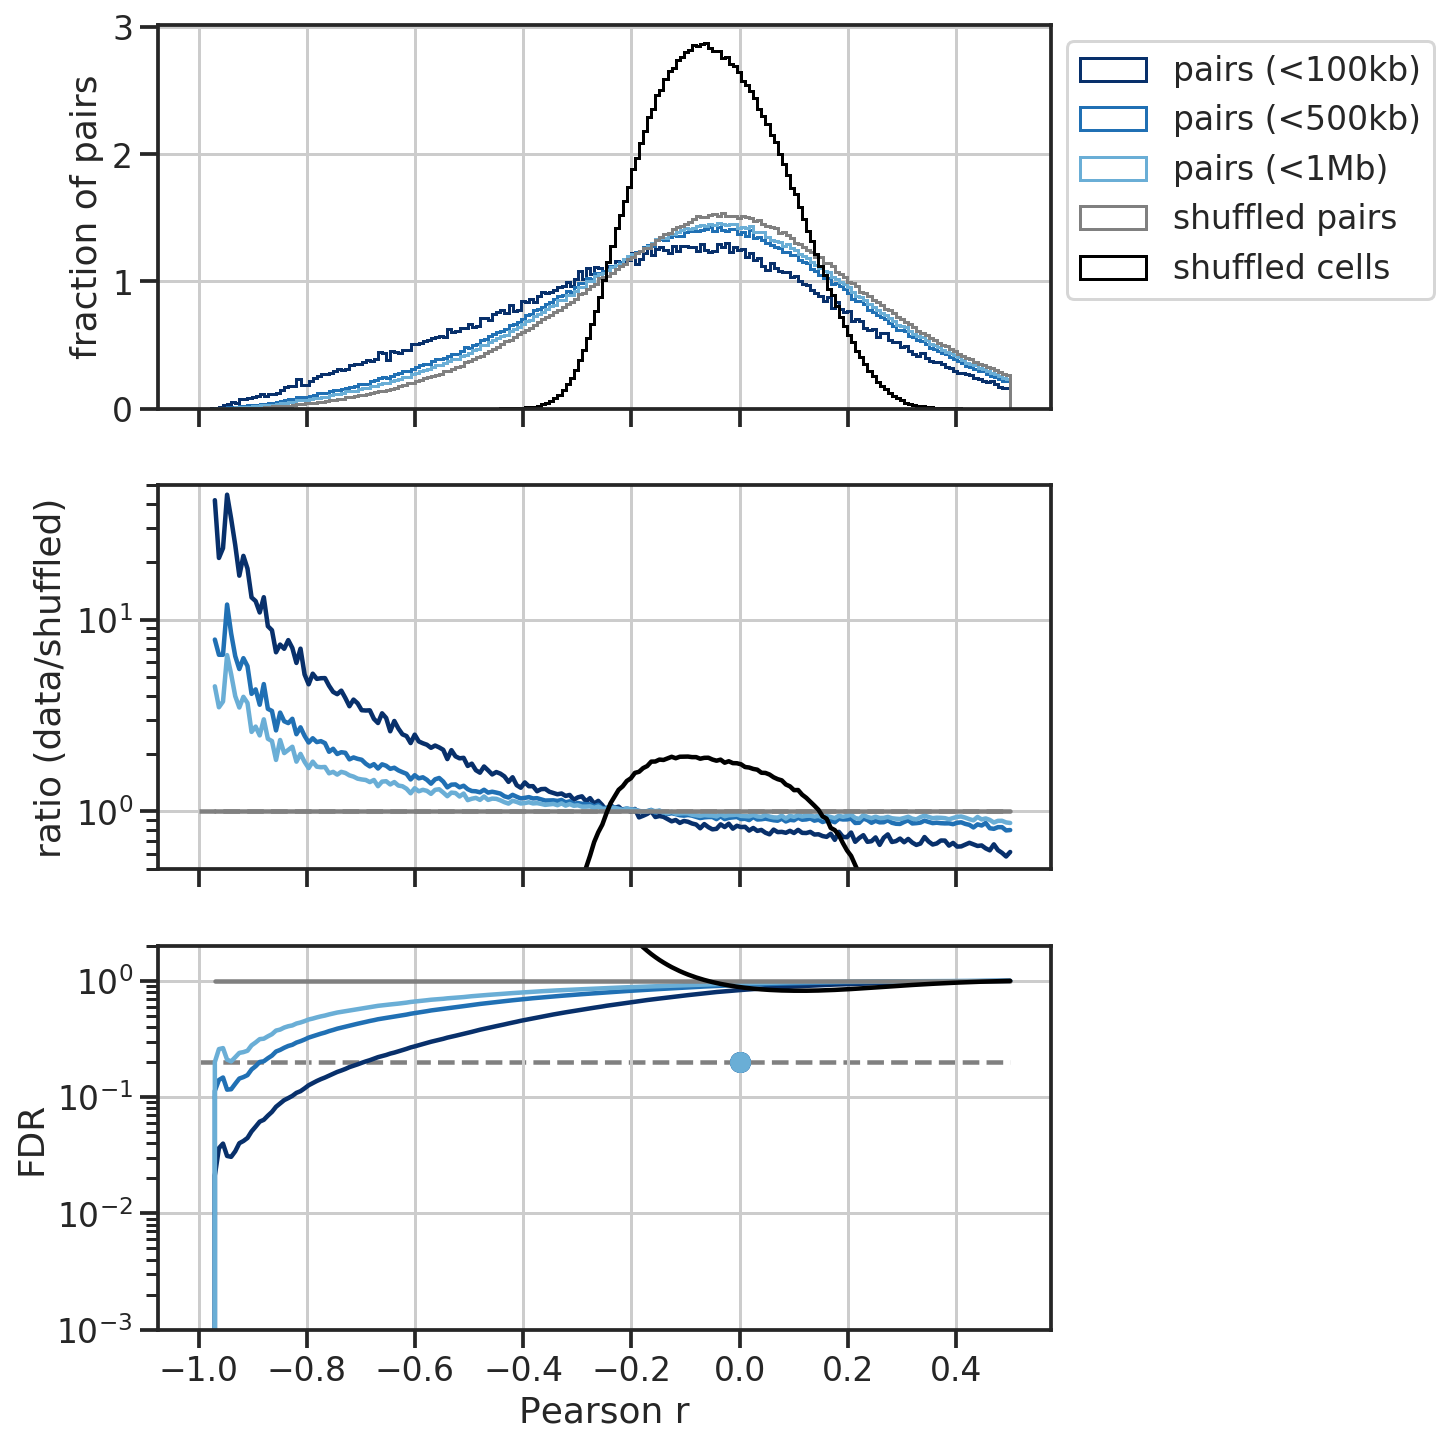

cluster_n108
Number of metacells: 108
(31053, 108) (233514, 108) (233514, 108)


11/20/2020 04:52:45 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(173052, 108)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150465 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

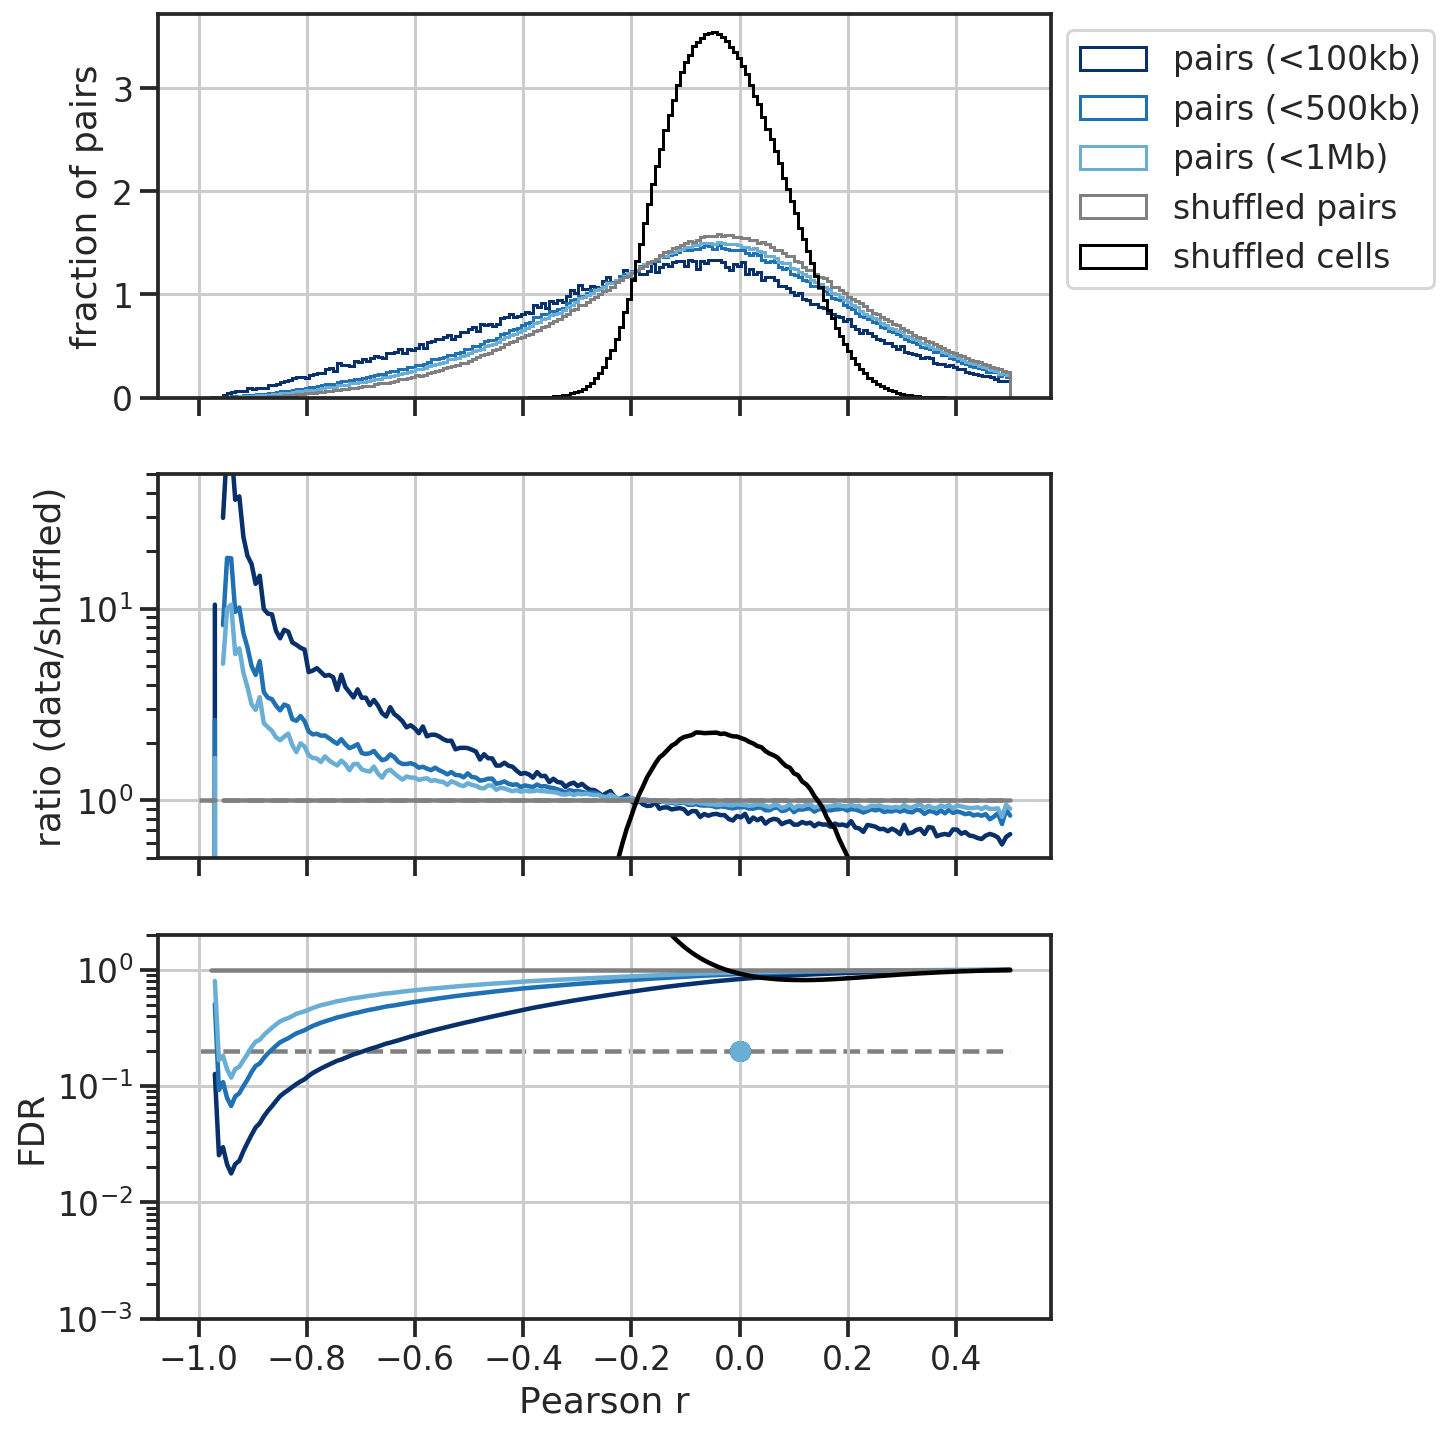

cluster_n134
Number of metacells: 134
(31053, 134) (233514, 134) (233514, 134)


11/20/2020 04:54:10 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172882, 134)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150439 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

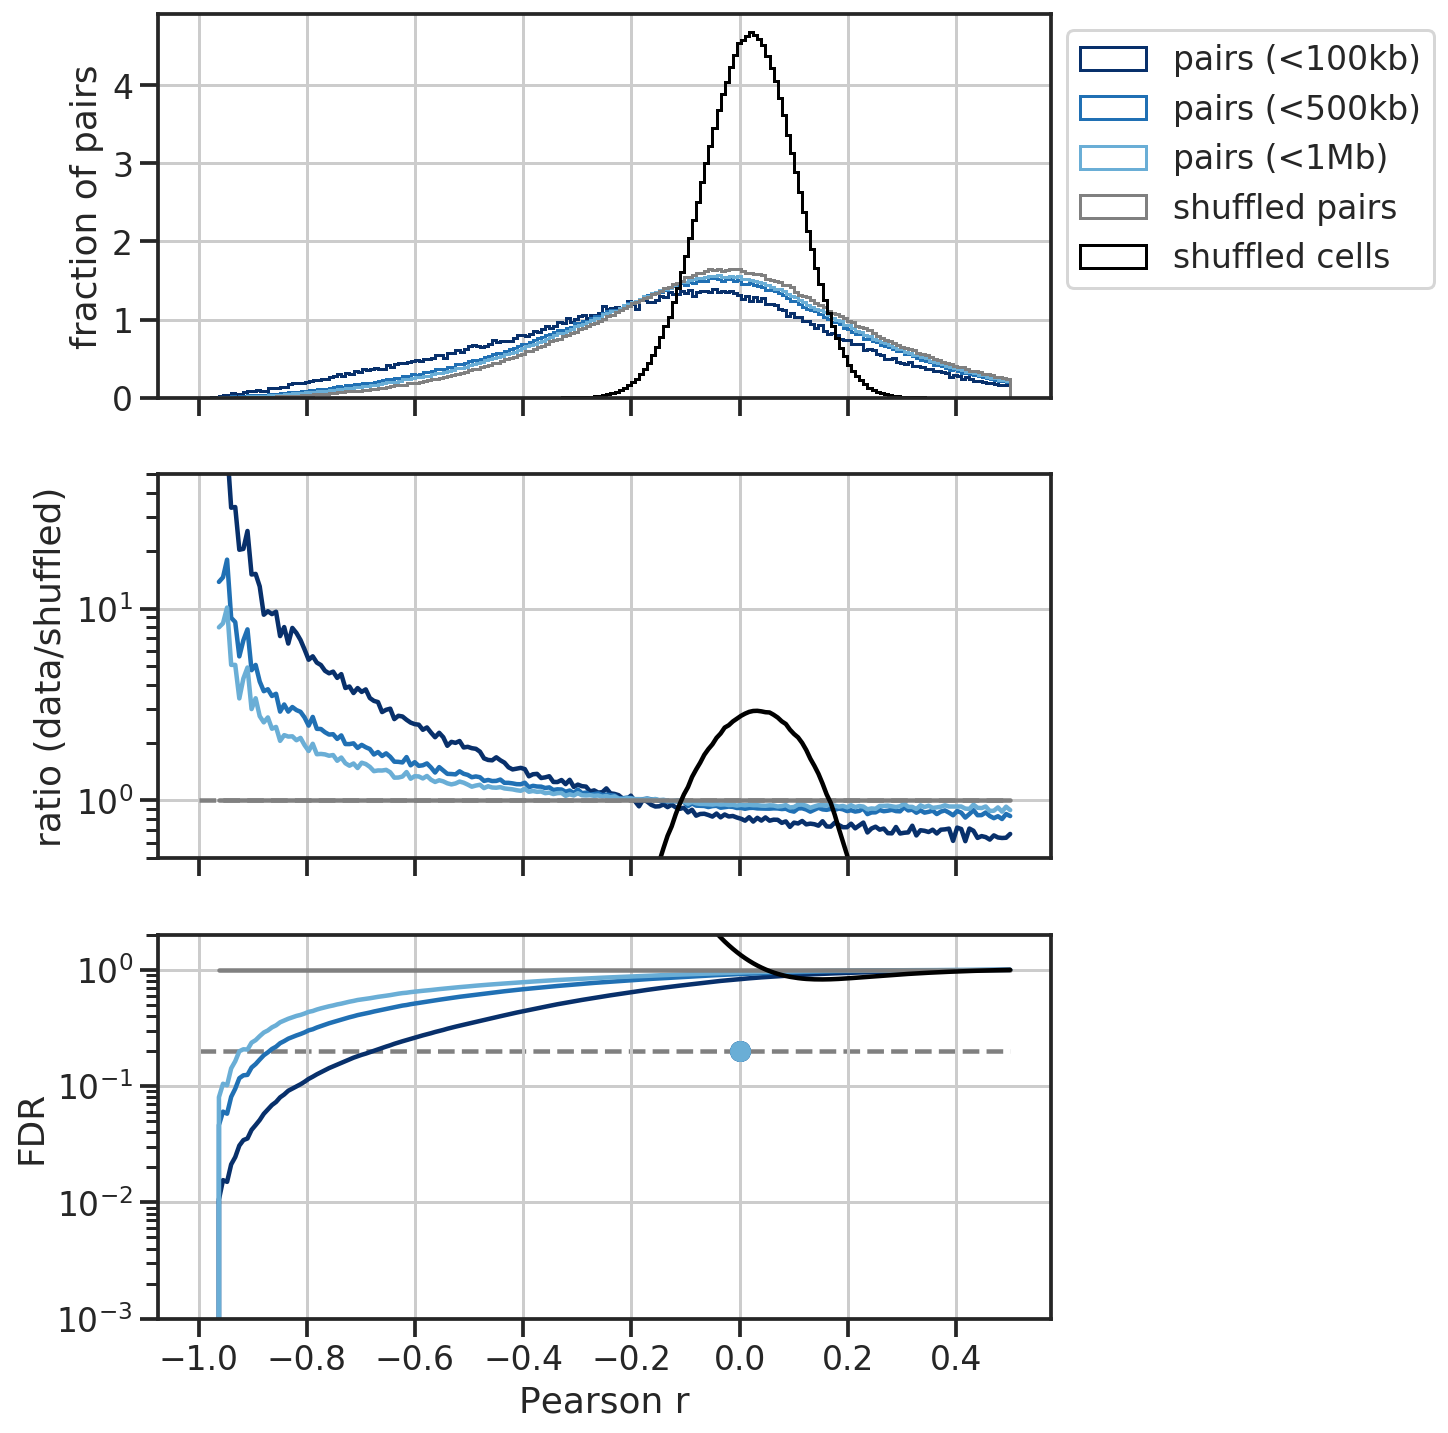

cluster_n164
Number of metacells: 164
(31053, 164) (233514, 164) (233514, 164)


11/20/2020 04:55:58 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172933, 164)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150451 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

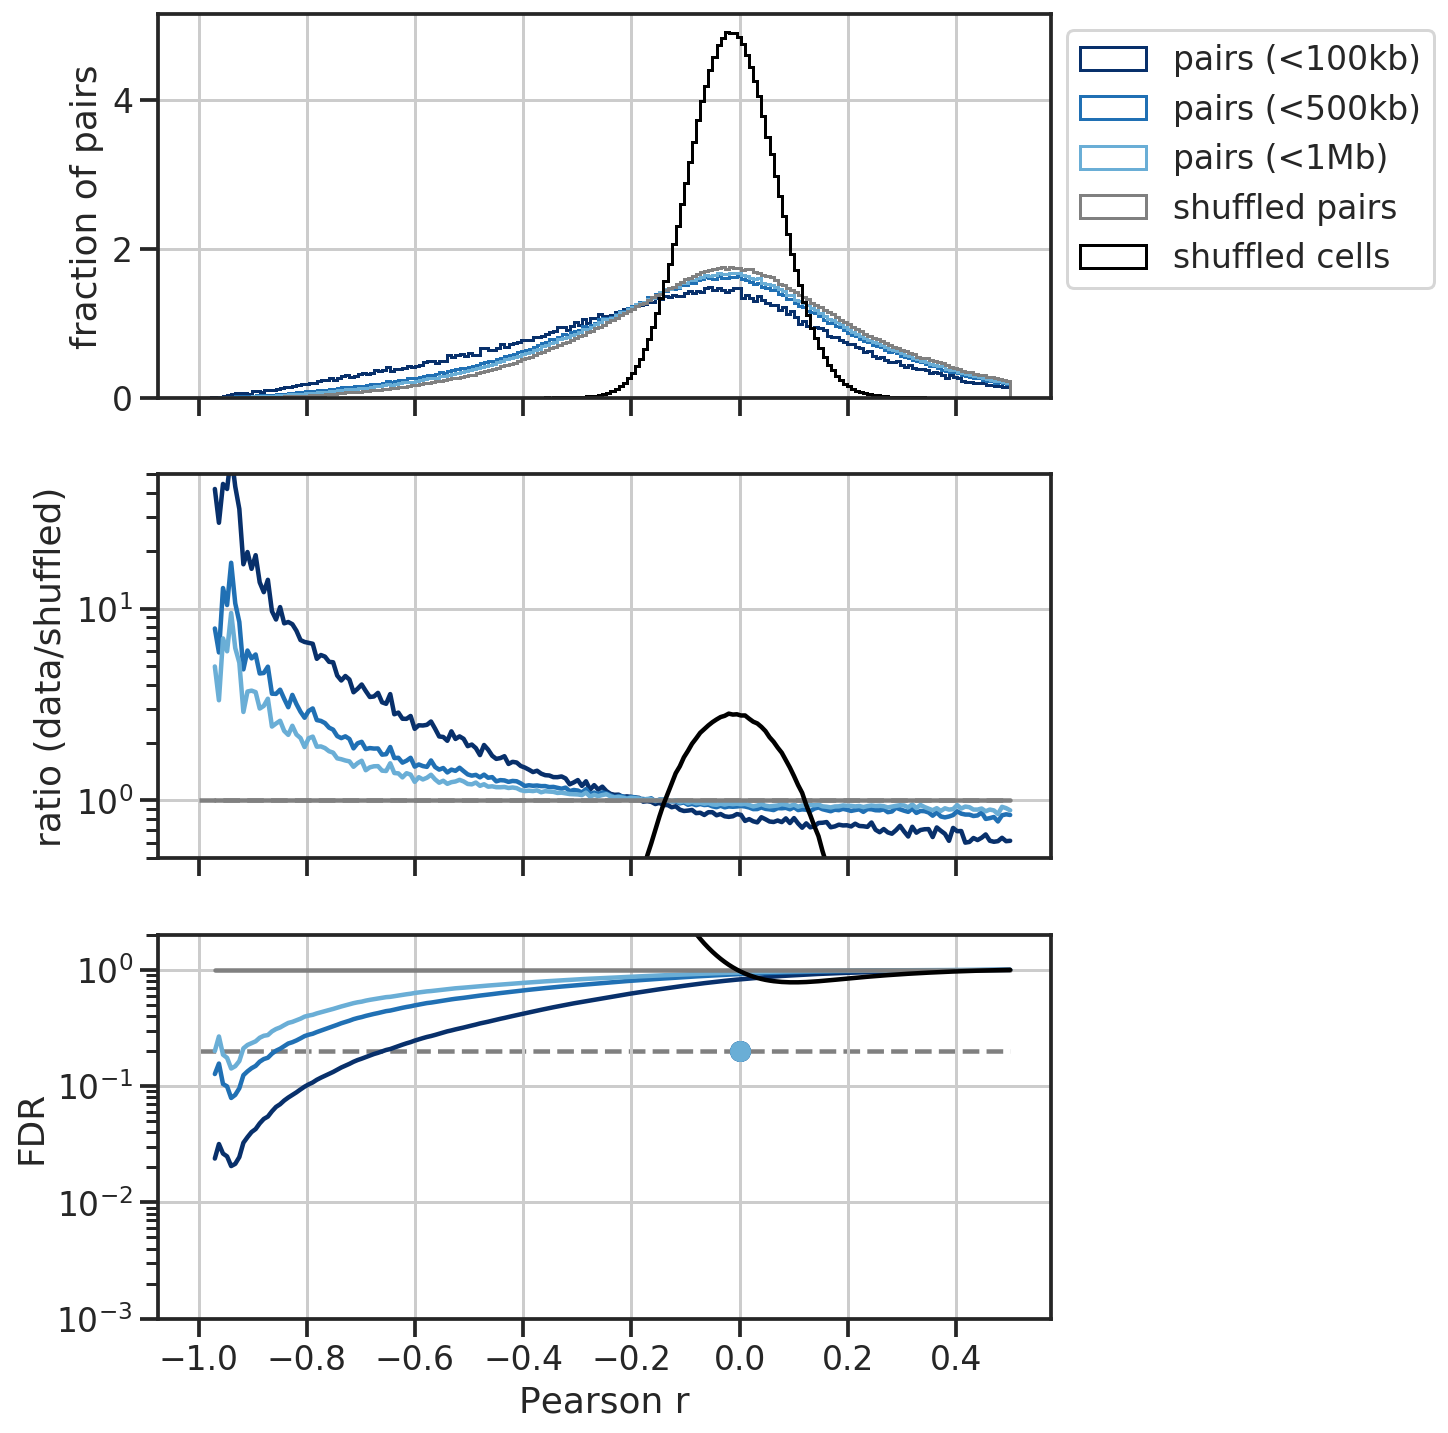

cluster_n205
Number of metacells: 205
(31053, 205) (233514, 205) (233514, 205)


11/20/2020 04:57:53 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172915, 205)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150441 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

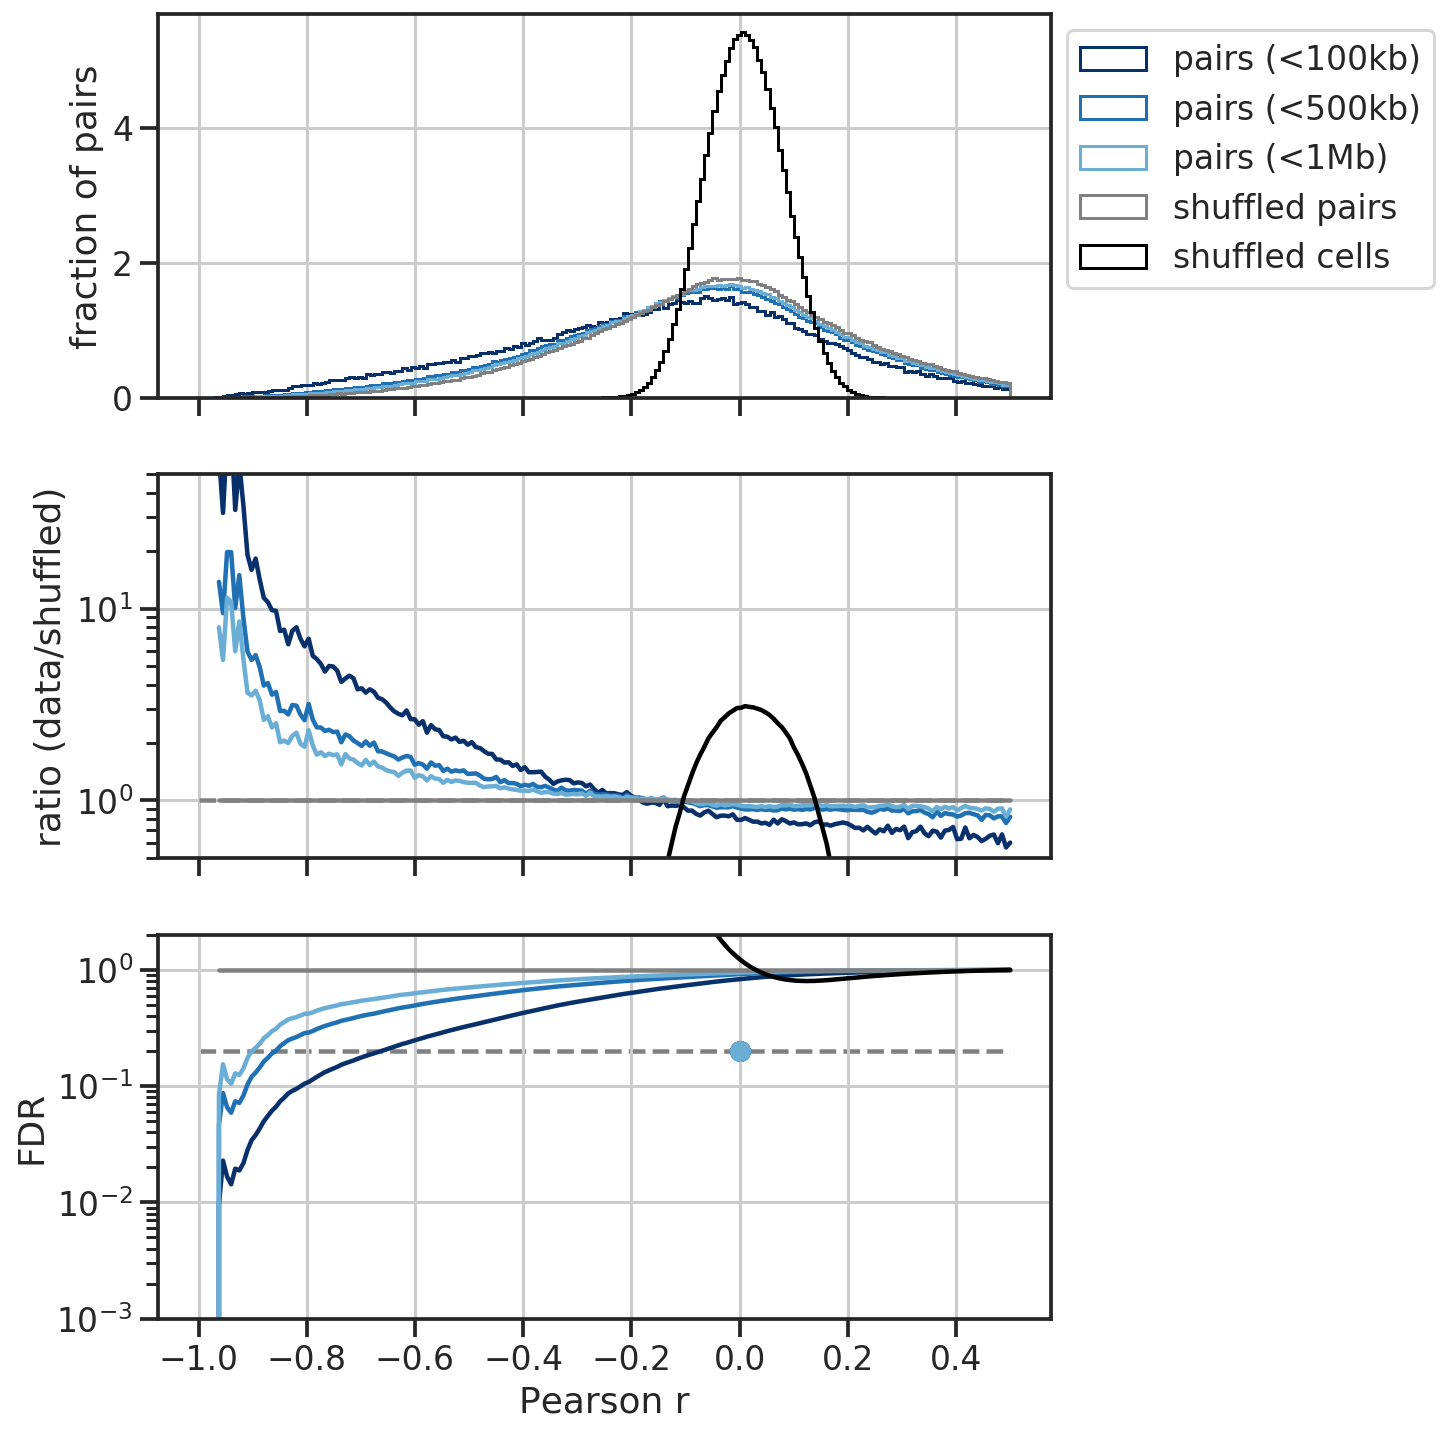

cluster_n256
Number of metacells: 256
(31053, 256) (233514, 256) (233514, 256)


11/20/2020 05:00:08 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172668, 256)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150414 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

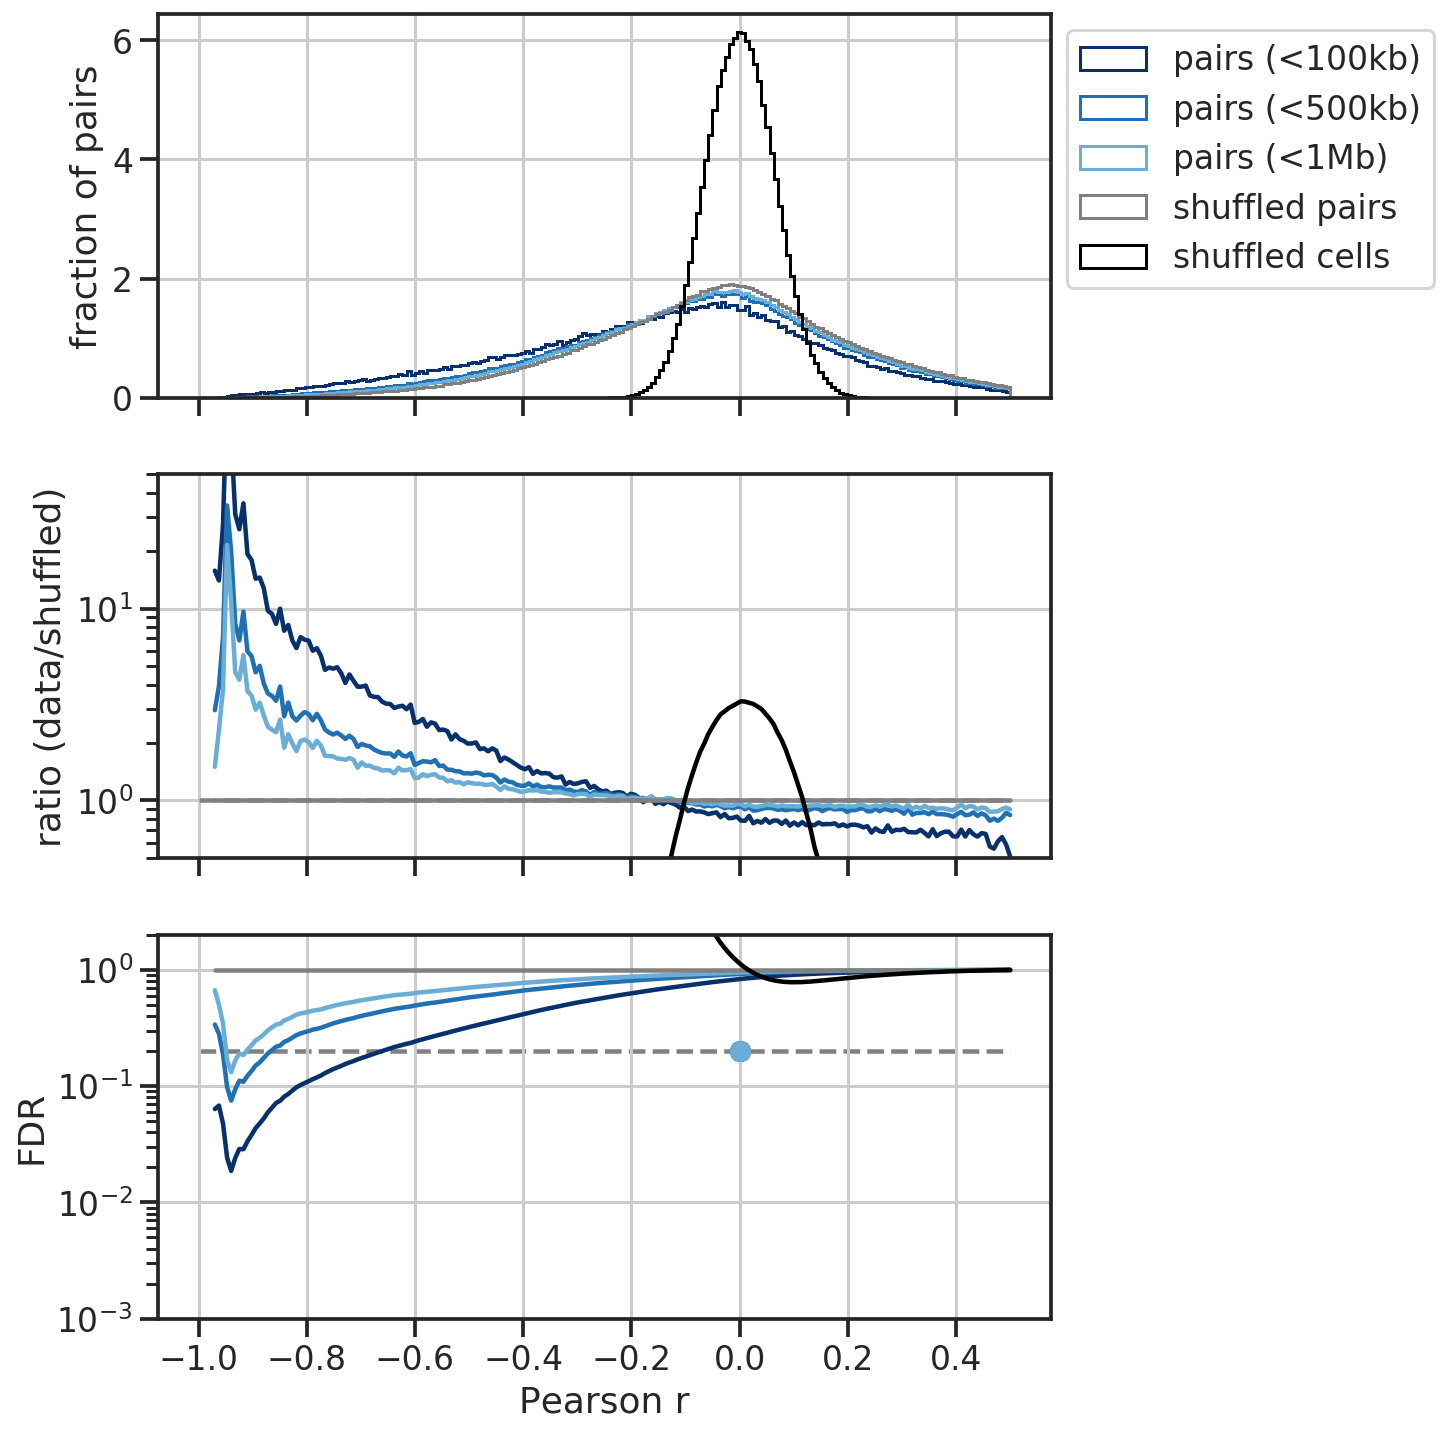

cluster_n319
Number of metacells: 319
(31053, 319) (233514, 319) (233514, 319)


11/20/2020 05:02:43 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172476, 319)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150391 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

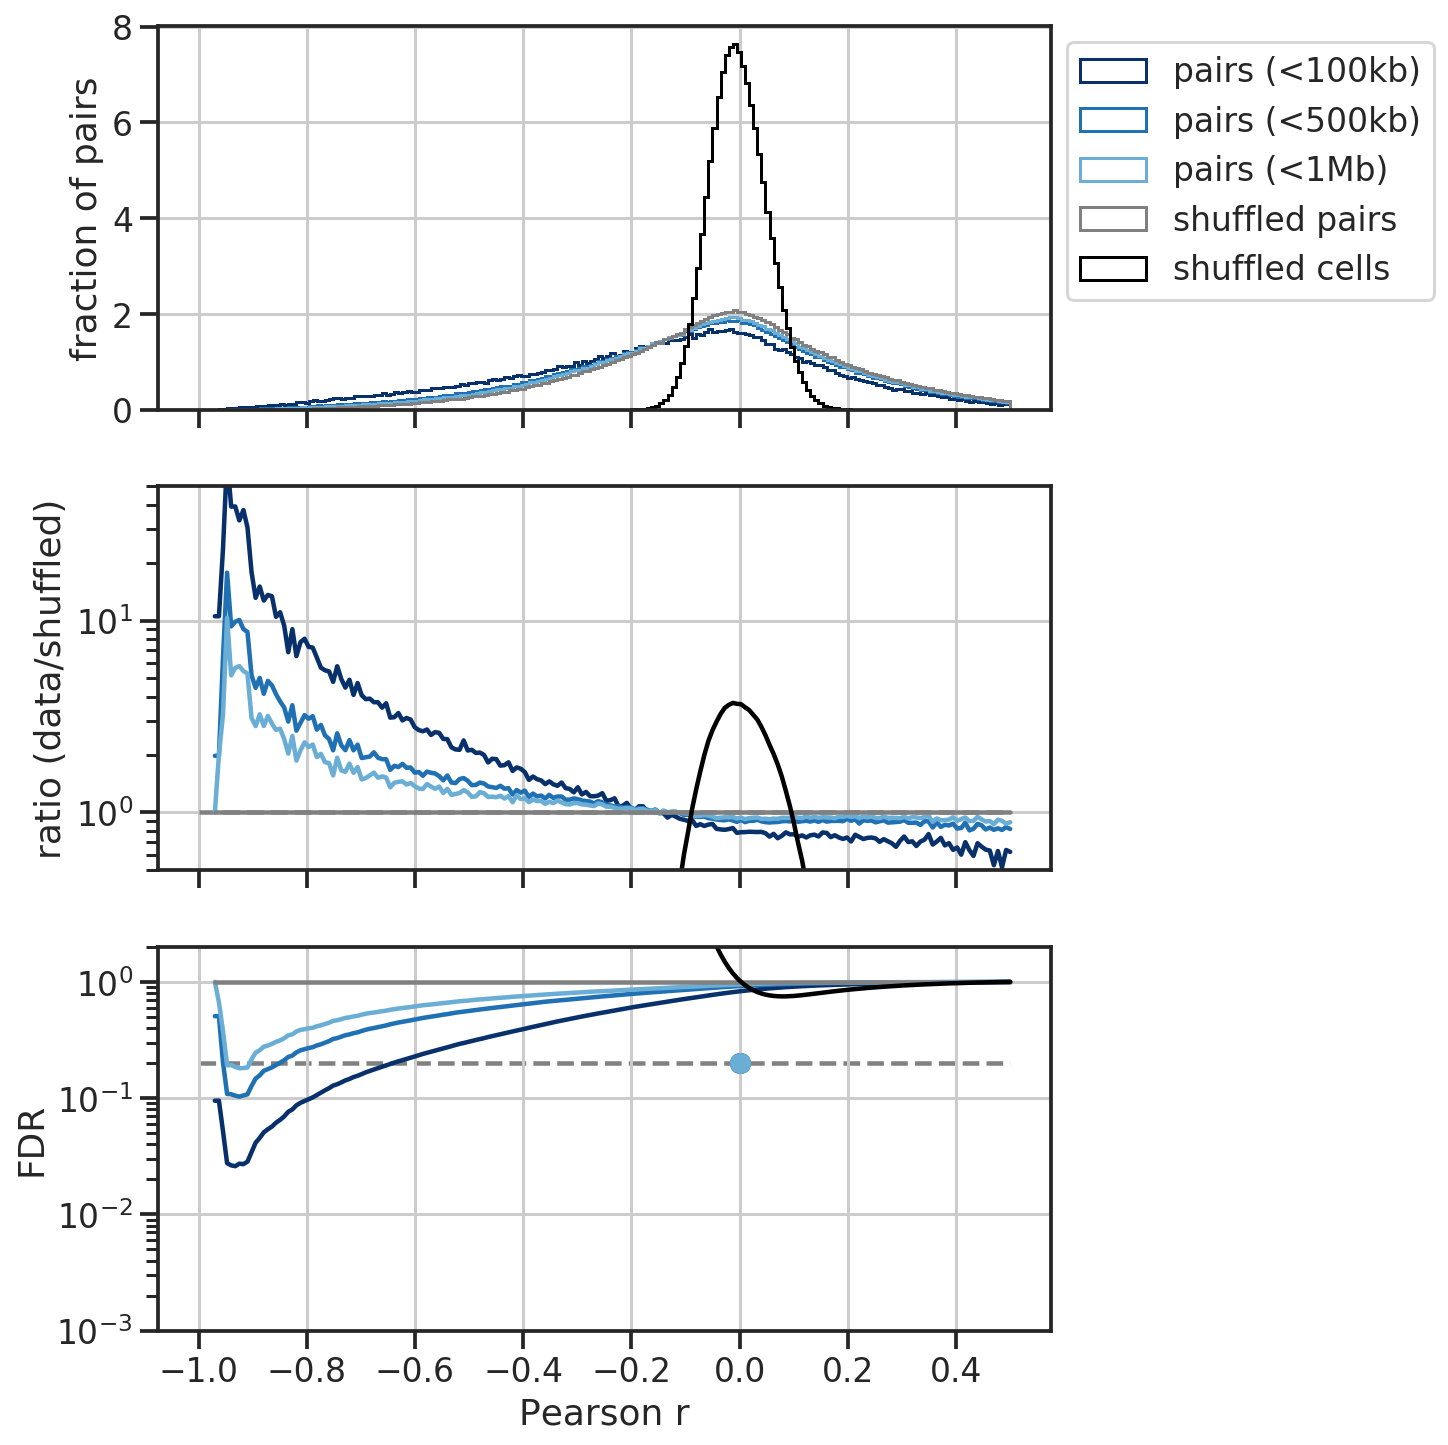

cluster_n398
Number of metacells: 398
(31053, 398) (233514, 398) (233514, 398)


11/20/2020 05:05:46 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172335, 398)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150369 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

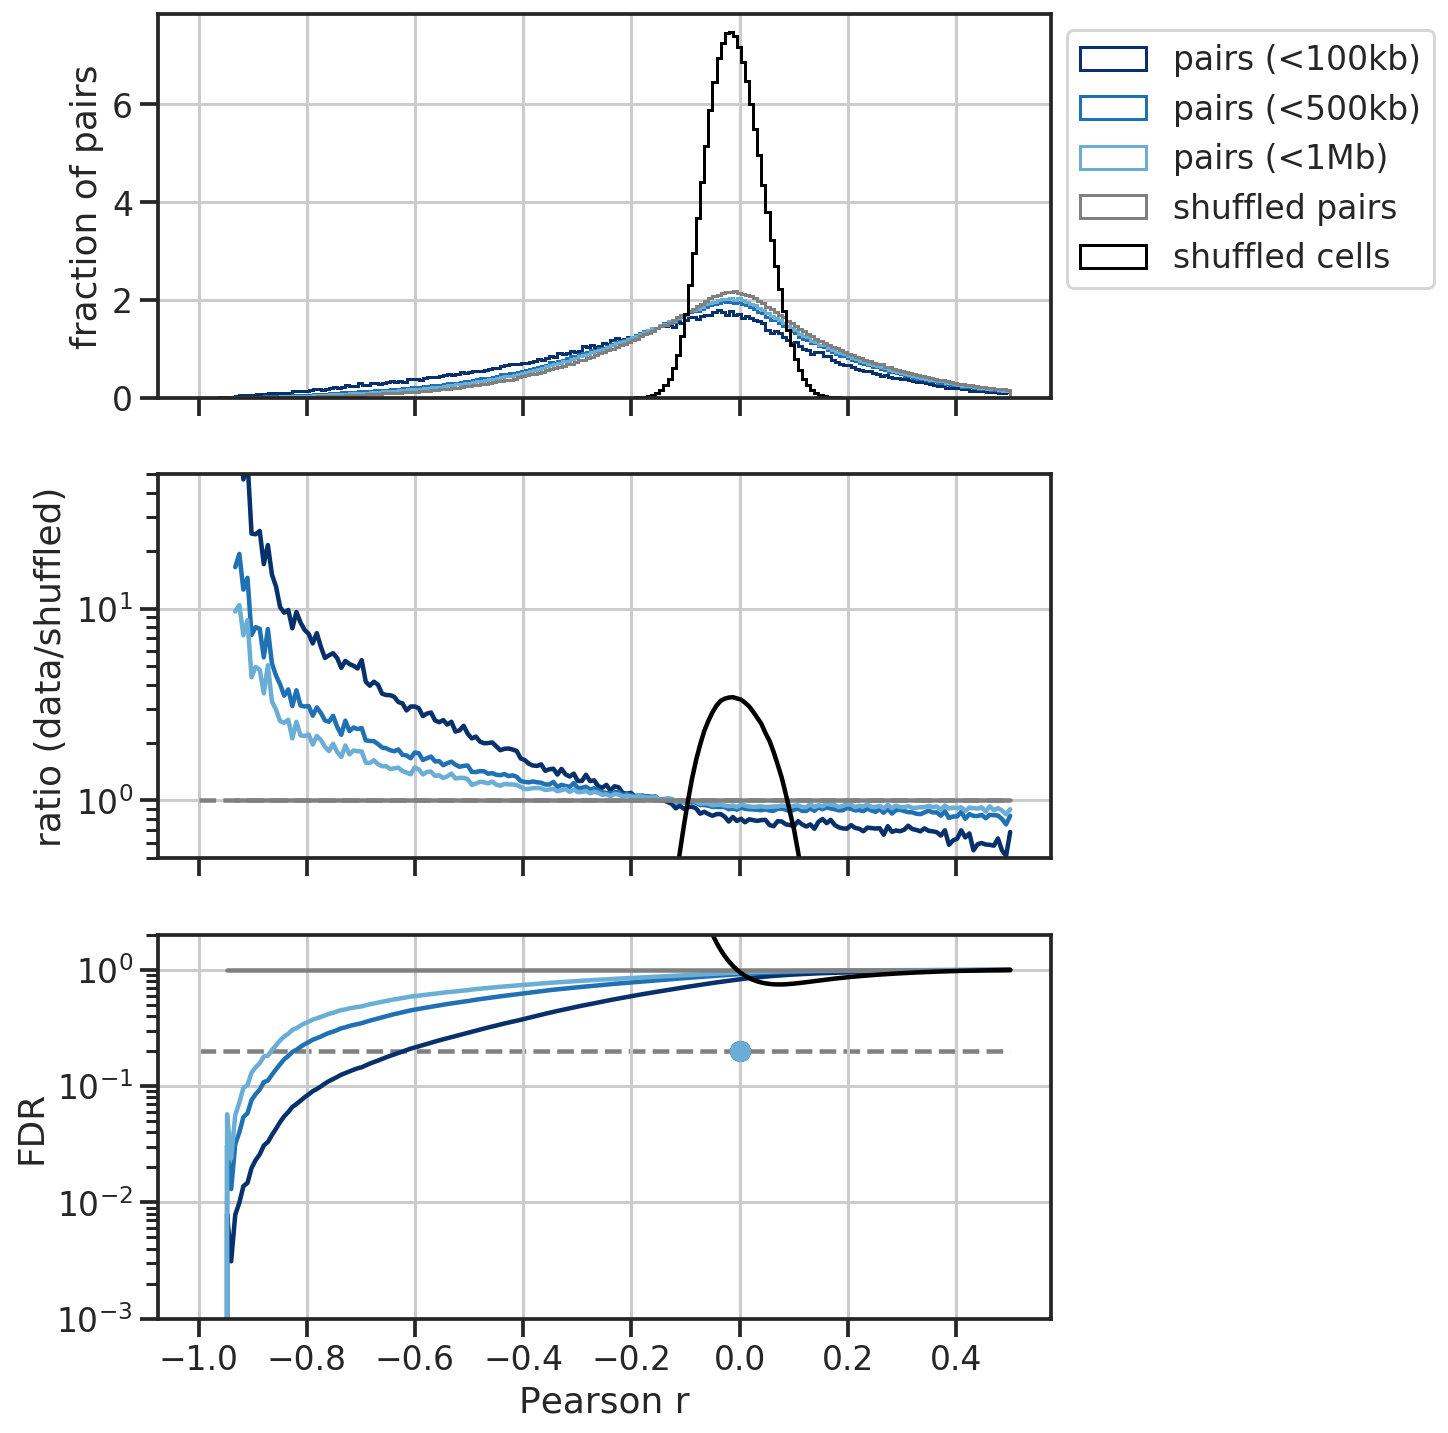

cluster_n488
Number of metacells: 488
(31053, 488) (233514, 488) (233514, 488)


11/20/2020 05:09:22 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(172107, 488)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150345 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

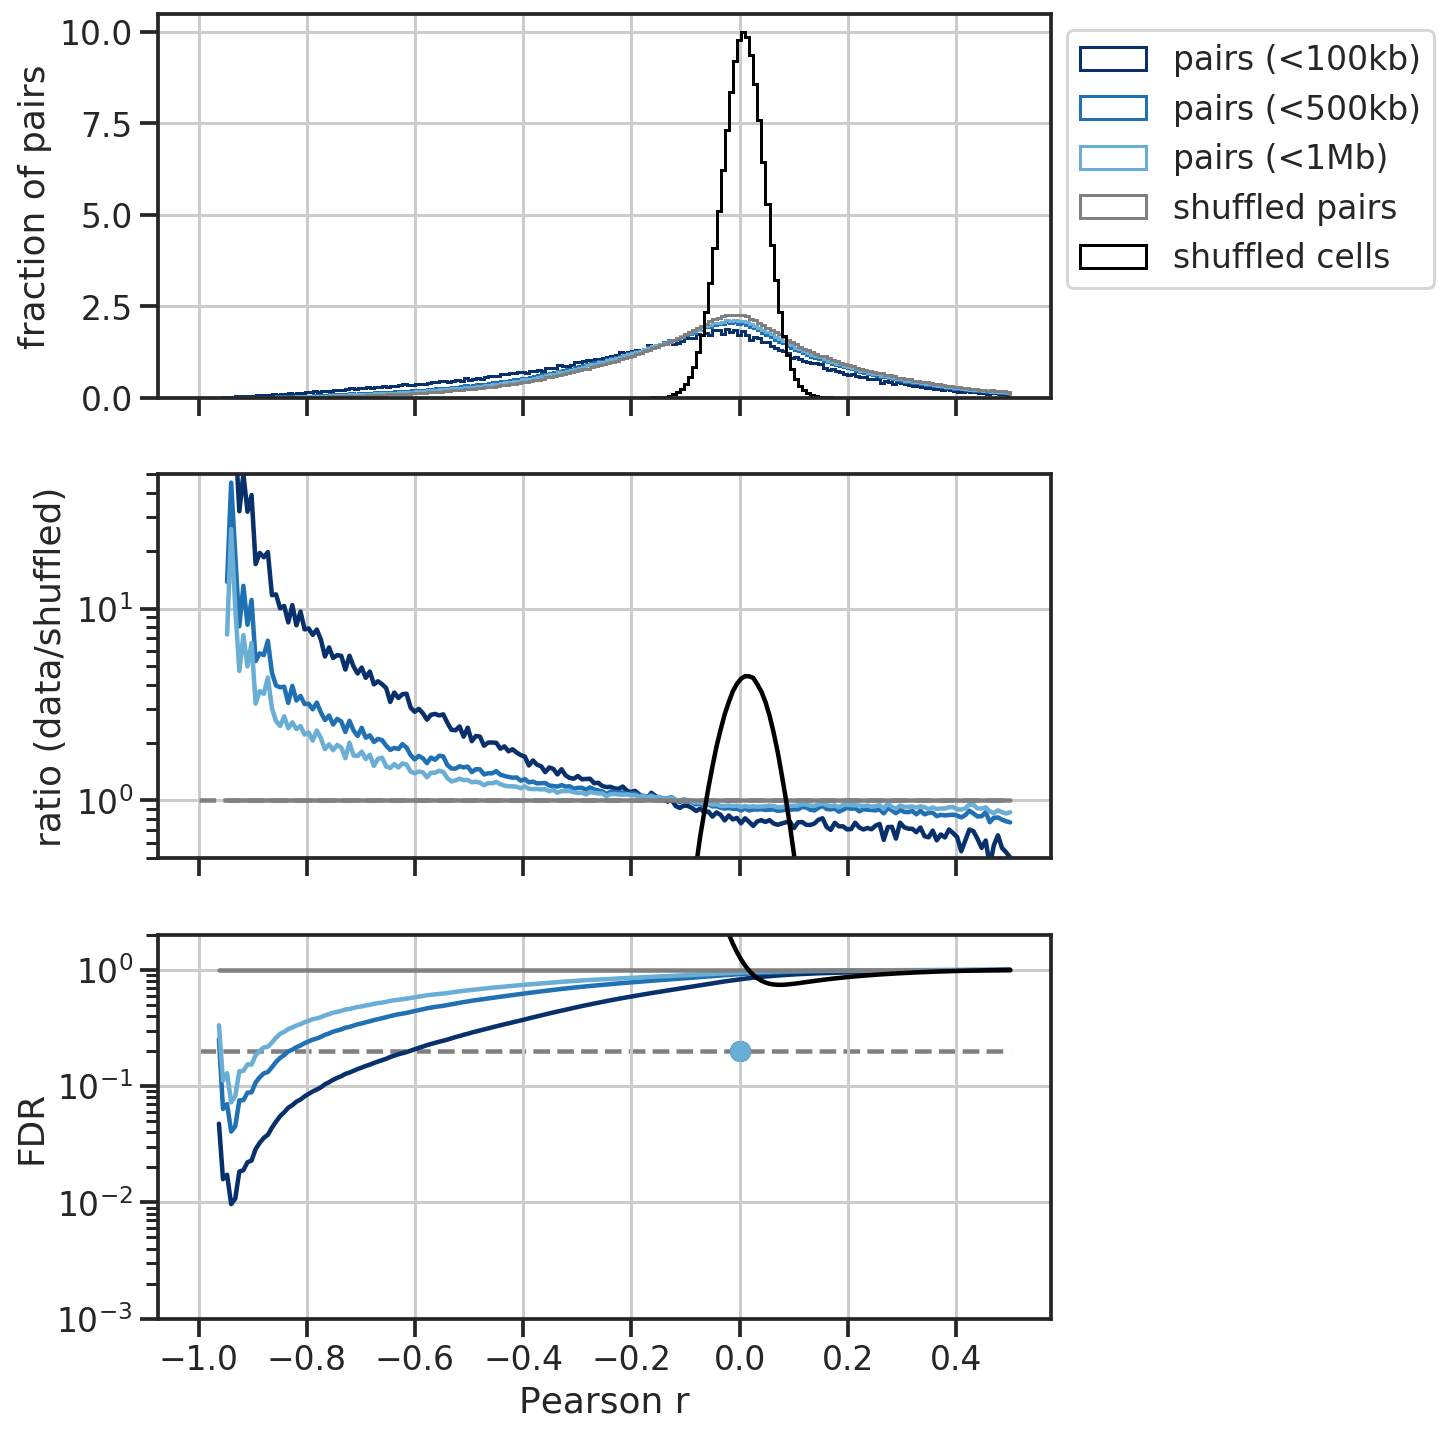

cluster_n611
Number of metacells: 611
(31053, 611) (233514, 611) (233514, 611)


11/20/2020 05:13:41 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(171897, 611)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150314 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

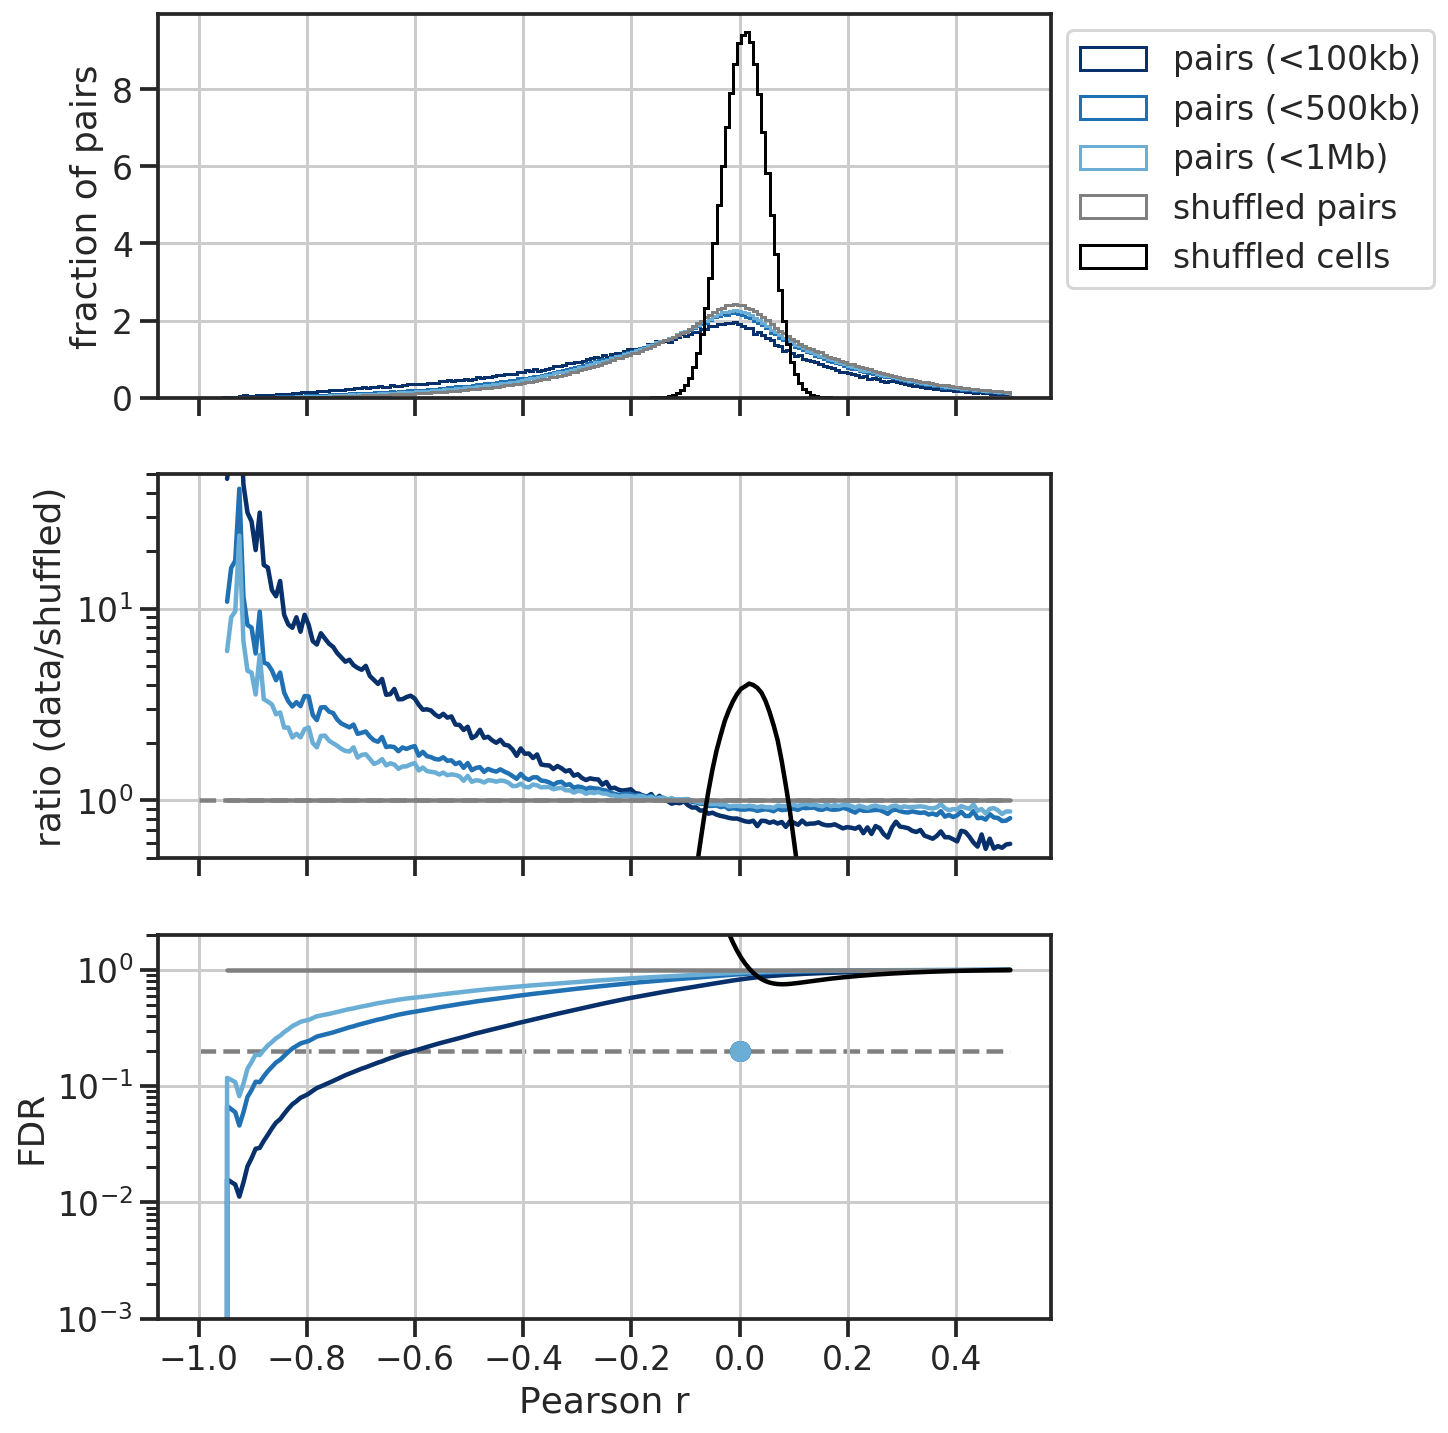

cluster_n749
Number of metacells: 749
(31053, 749) (233514, 749) (233514, 749)


11/20/2020 05:19:10 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(171639, 749)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2062 1000000
150285 16775


<ipython-input-10-57b6e01b0941>:93: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:95: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-10-57b6e01b0941>:99: VisibleDeprecationWarning: Passing `normed

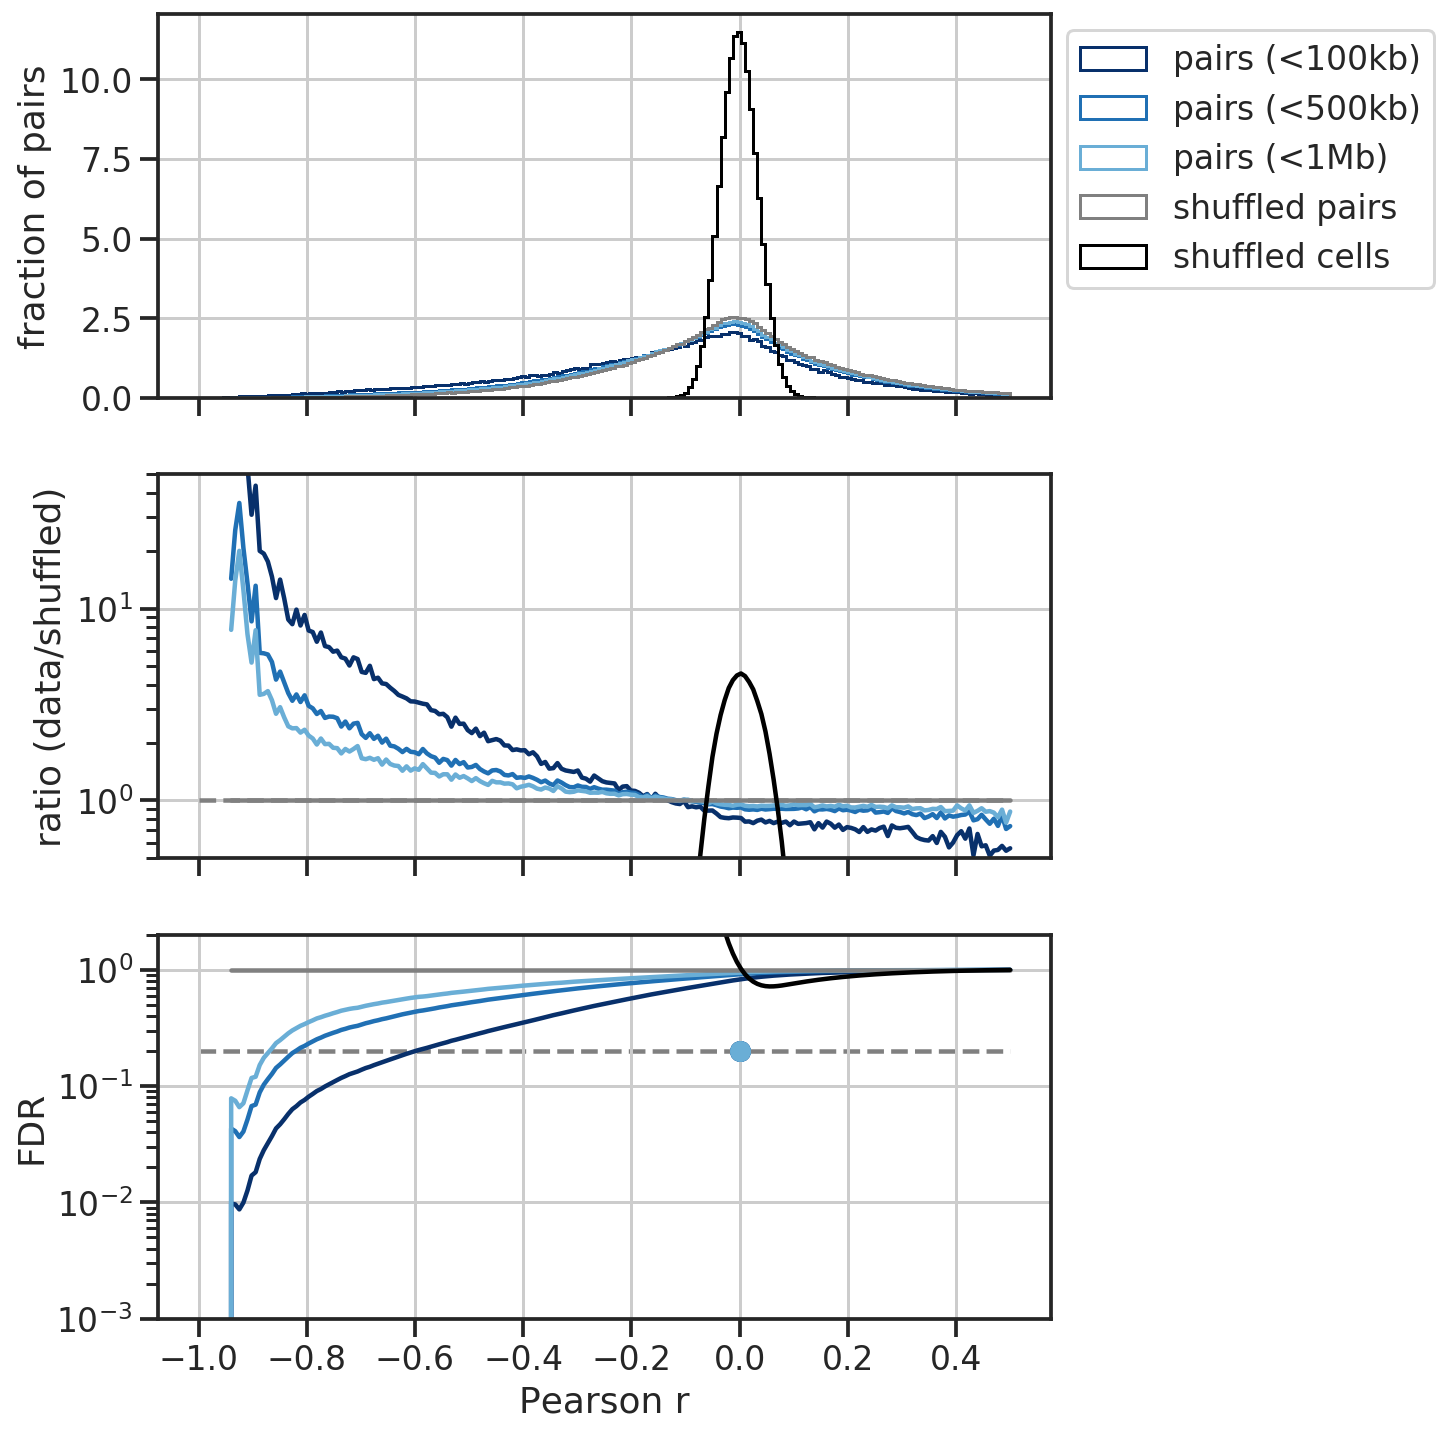

cluster_n938
Number of metacells: 938
(31053, 938) (233514, 938) (233514, 938)


11/20/2020 05:25:17 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(171445, 938)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [ ]:
for clst_col in modx_clsts.columns: 
    print(clst_col)
    
    # choose one clustering to proceed
    uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
    print("Number of metacells: {}".format(len(uniq_labels)))

    knn_xz = turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                        uniq_labels,
                                       )
    # normalization - such that metacells made of more cells still sums to 1
    knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))
    
    # gene by metacell
    gc_rna = X.dot(knn_xz).todense() 

    # enhancer by metacell
    knn_yz = knn_xy.T.dot(knn_xz)
    ec_cg = Y_cg.dot(knn_yz).todense() 
    ec_mcg = Y_mcg.dot(knn_yz).todense()  
    print(gc_rna.shape, ec_cg.shape, ec_mcg.shape)
    
    # mC
    ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                   pd.DataFrame(ec_cg).astype(np.float32), 
                                   pd.DataFrame(ec_mcg).astype(np.float32), 
                                   base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
    print(ec_mccg.shape)
    
    # corr analysis
    output_corr = output_corrs.format(clst_col)
    (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = compute_enh_gene_corrs(
        gc_rna, ec_mccg, 
        enhancer_gene_to_eval, 
        common_genes, ec_mccg.index.values,
        output_file=output_corr, chunksize=100000, verbose_level=0,
        )
    
    # plotting
    # some basic stats
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    uniq_enh = enhancer_gene_to_eval.loc[to_correlate, 'ens'].unique()
    uniq_gene = enhancer_gene_to_eval.loc[to_correlate, 'gene'].unique()

    print(np.min(dists), np.max(dists))
    print(len(uniq_enh), len(uniq_gene))

    # plotting setup
    num_bins = 200
    bin_min, bin_max = -1, 0.5
    fdr_threshold = 0.2
    bins = np.linspace(bin_min, bin_max, num_bins)

    tracks = {
        'pairs (<100kb)': corrs[dists<1e5], 
        'pairs (<500kb)': corrs[dists<5e5], 
        'pairs (<1Mb)': corrs, 
        'shuffled pairs': corrs_shuffled, 
        'shuffled cells': corrs_shuffled_cells, 
        }

    colors = snmcseq_utils.get_grad_colors(len(tracks), cmap='Blues_r')
    track_colors = {
        'pairs (<100kb)': colors[0], 
        'pairs (<500kb)': colors[1], 
        'pairs (<1Mb)': colors[2], 
        'shuffled pairs': 'gray', 
        'shuffled cells': 'black', 
        }

    config = {
        'kde': False,
        "hist_kws": {
                    'histtype': 'step', 
    #                 'edgecolor': 'none',
                    'alpha': 1, 
                    'density': True, 
                    },
    }

    track_pdf_ratios = {}
    track_cdfs = {}
    track_fdrs = {}

    track_r_thresholds = {}
    track_num_sigs = {}
    track_frac_sigs = {}

    track_r_thresholds_cells = {}
    track_num_sigs_cells = {}
    track_frac_sigs_cells = {}

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
    cdf_shuff = np.cumsum(hist_shuff)
    hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
    cdf_shuff_cells = np.cumsum(hist_shuff_cells)
    for label, track in tracks.items():
        # dist
        hist, _ = np.histogram(track, bins=bins, normed=True)
        cdf = np.cumsum(hist)
        # fdr
        fdr = cdf_shuff/cdf
        fdr_cells = cdf_shuff_cells/cdf
        # record
        track_pdf_ratios[label] = hist/hist_shuff
        track_cdfs[label] = cdf 
        track_fdrs[label] = fdr

        if label.startswith("pairs"):
            # get r_threshold
            # remove nan
            isnan = np.isnan(fdr)
            _y = fdr[~isnan]
            _x = bins[1:][~isnan]

            # find r threshold
            try:
                f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
                r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
            except:
                r_threshold = 0

            # num and frac significant
            num_sig = np.sum(track < r_threshold)
            frac_sig = num_sig/len(track)

            # record
            track_r_thresholds[label] = r_threshold 
            track_num_sigs[label] = num_sig
            track_frac_sigs[label] = frac_sig

            ## shuff cells
            # get r_threshold
            # remove nan
            isnan = np.isnan(fdr_cells)
            _y = fdr_cells[~isnan]
            _x = bins[1:][~isnan]

            # find r threshold
            try:
                f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
                r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
            except:
                r_threshold = 0

            # num and frac significant
            num_sig = np.sum(track < r_threshold)
            frac_sig = num_sig/len(track)

            # record
            track_r_thresholds_cells[label] = r_threshold 
            track_num_sigs_cells[label] = num_sig
            track_frac_sigs_cells[label] = frac_sig
    
    
    # figure 2
    fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

    ax = axs[0]
    for label, track in tracks.items():
        sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.set_ylabel('fraction of pairs')
    # ax.set_ylim([0, 6])

    ax = axs[1]
    for label, track in track_pdf_ratios.items():
        ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
    ax.set_yscale('log')
    ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
    ax.set_ylabel('ratio (data/shuffled)')
    ax.set_ylim([0.5, 50])

    ax = axs[2]
    for label, track in track_fdrs.items():
        ax.plot(bins[1:], track, color=track_colors[label])
        if label.startswith('pairs'):
            ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
    ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)

    ax.set_yscale('log')
    ax.set_ylabel('FDR')
    ax.set_xlabel('Pearson r')
    ax.set_ylim([1e-3, 2])

    snmcseq_utils.savefig(fig, output_figures.format("corr_dist_plot_"+clst_col))
    plt.show()

# plotting results

In [15]:
# enhancer-gene linkage table (needed to interpret the results)
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)

# results
with open(output_corr, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(to_correlate.shape, corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

(2589994, 18)
(2589994,) (2334868,) (2334868,) (2334868,)


In [16]:
# some basic stats
dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
uniq_enh = enhancer_gene_to_eval.loc[to_correlate, 'ens'].unique()
uniq_gene = enhancer_gene_to_eval.loc[to_correlate, 'gene'].unique()

print(np.min(dists), np.max(dists))
print(len(uniq_enh), len(uniq_gene))

2062 1000000
150529 16775


In [17]:
# plotting setup

num_bins = 200
bin_min, bin_max = -1, 0.5
fdr_threshold = 0.2
bins = np.linspace(bin_min, bin_max, num_bins)


tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    'shuffled cells': corrs_shuffled_cells, 
    }


colors = snmcseq_utils.get_grad_colors(len(tracks), cmap='Blues_r')
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    'shuffled cells': 'black', 
    }


config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}


In [18]:

track_pdf_ratios = {}
track_cdfs = {}
track_fdrs = {}

track_r_thresholds = {}
track_num_sigs = {}
track_frac_sigs = {}

track_r_thresholds_cells = {}
track_num_sigs_cells = {}
track_frac_sigs_cells = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
cdf_shuff_cells = np.cumsum(hist_shuff_cells)
for label, track in tracks.items():
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf
    fdr_cells = cdf_shuff_cells/cdf
    # record
    track_pdf_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    track_fdrs[label] = fdr
    
    if label.startswith("pairs"):
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr)
        _y = fdr[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds[label] = r_threshold 
        track_num_sigs[label] = num_sig
        track_frac_sigs[label] = frac_sig
    
        ## shuff cells
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr_cells)
        _y = fdr_cells[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds_cells[label] = r_threshold 
        track_num_sigs_cells[label] = num_sig
        track_frac_sigs_cells[label] = frac_sig

<ipython-input-18-b36d64745046>:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-18-b36d64745046>:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-18-b36d64745046>:19: VisibleDeprecationWarning: Passing `normed

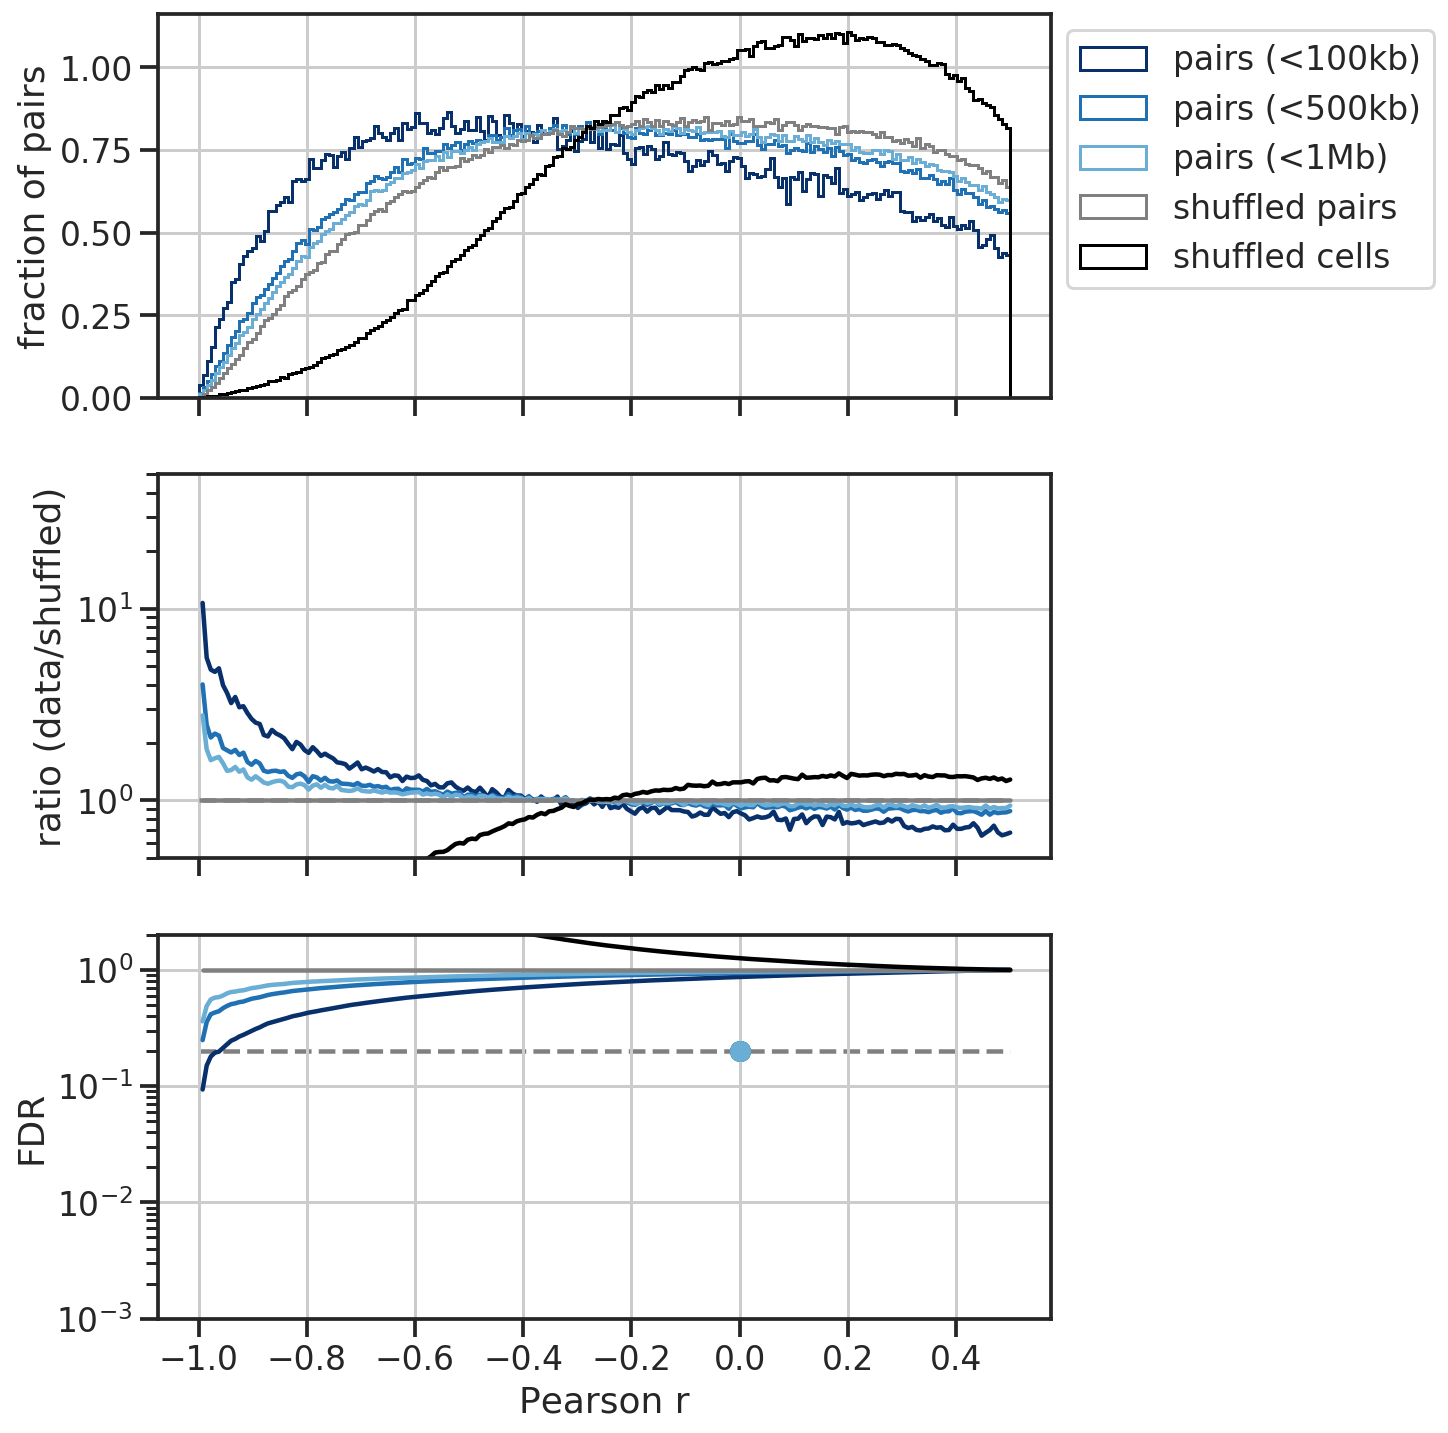

In [19]:
# figure 2
fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
# ax.set_ylim([0, 6])

ax = axs[1]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[2]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figures.format("corr_dist_plot"))
plt.show()

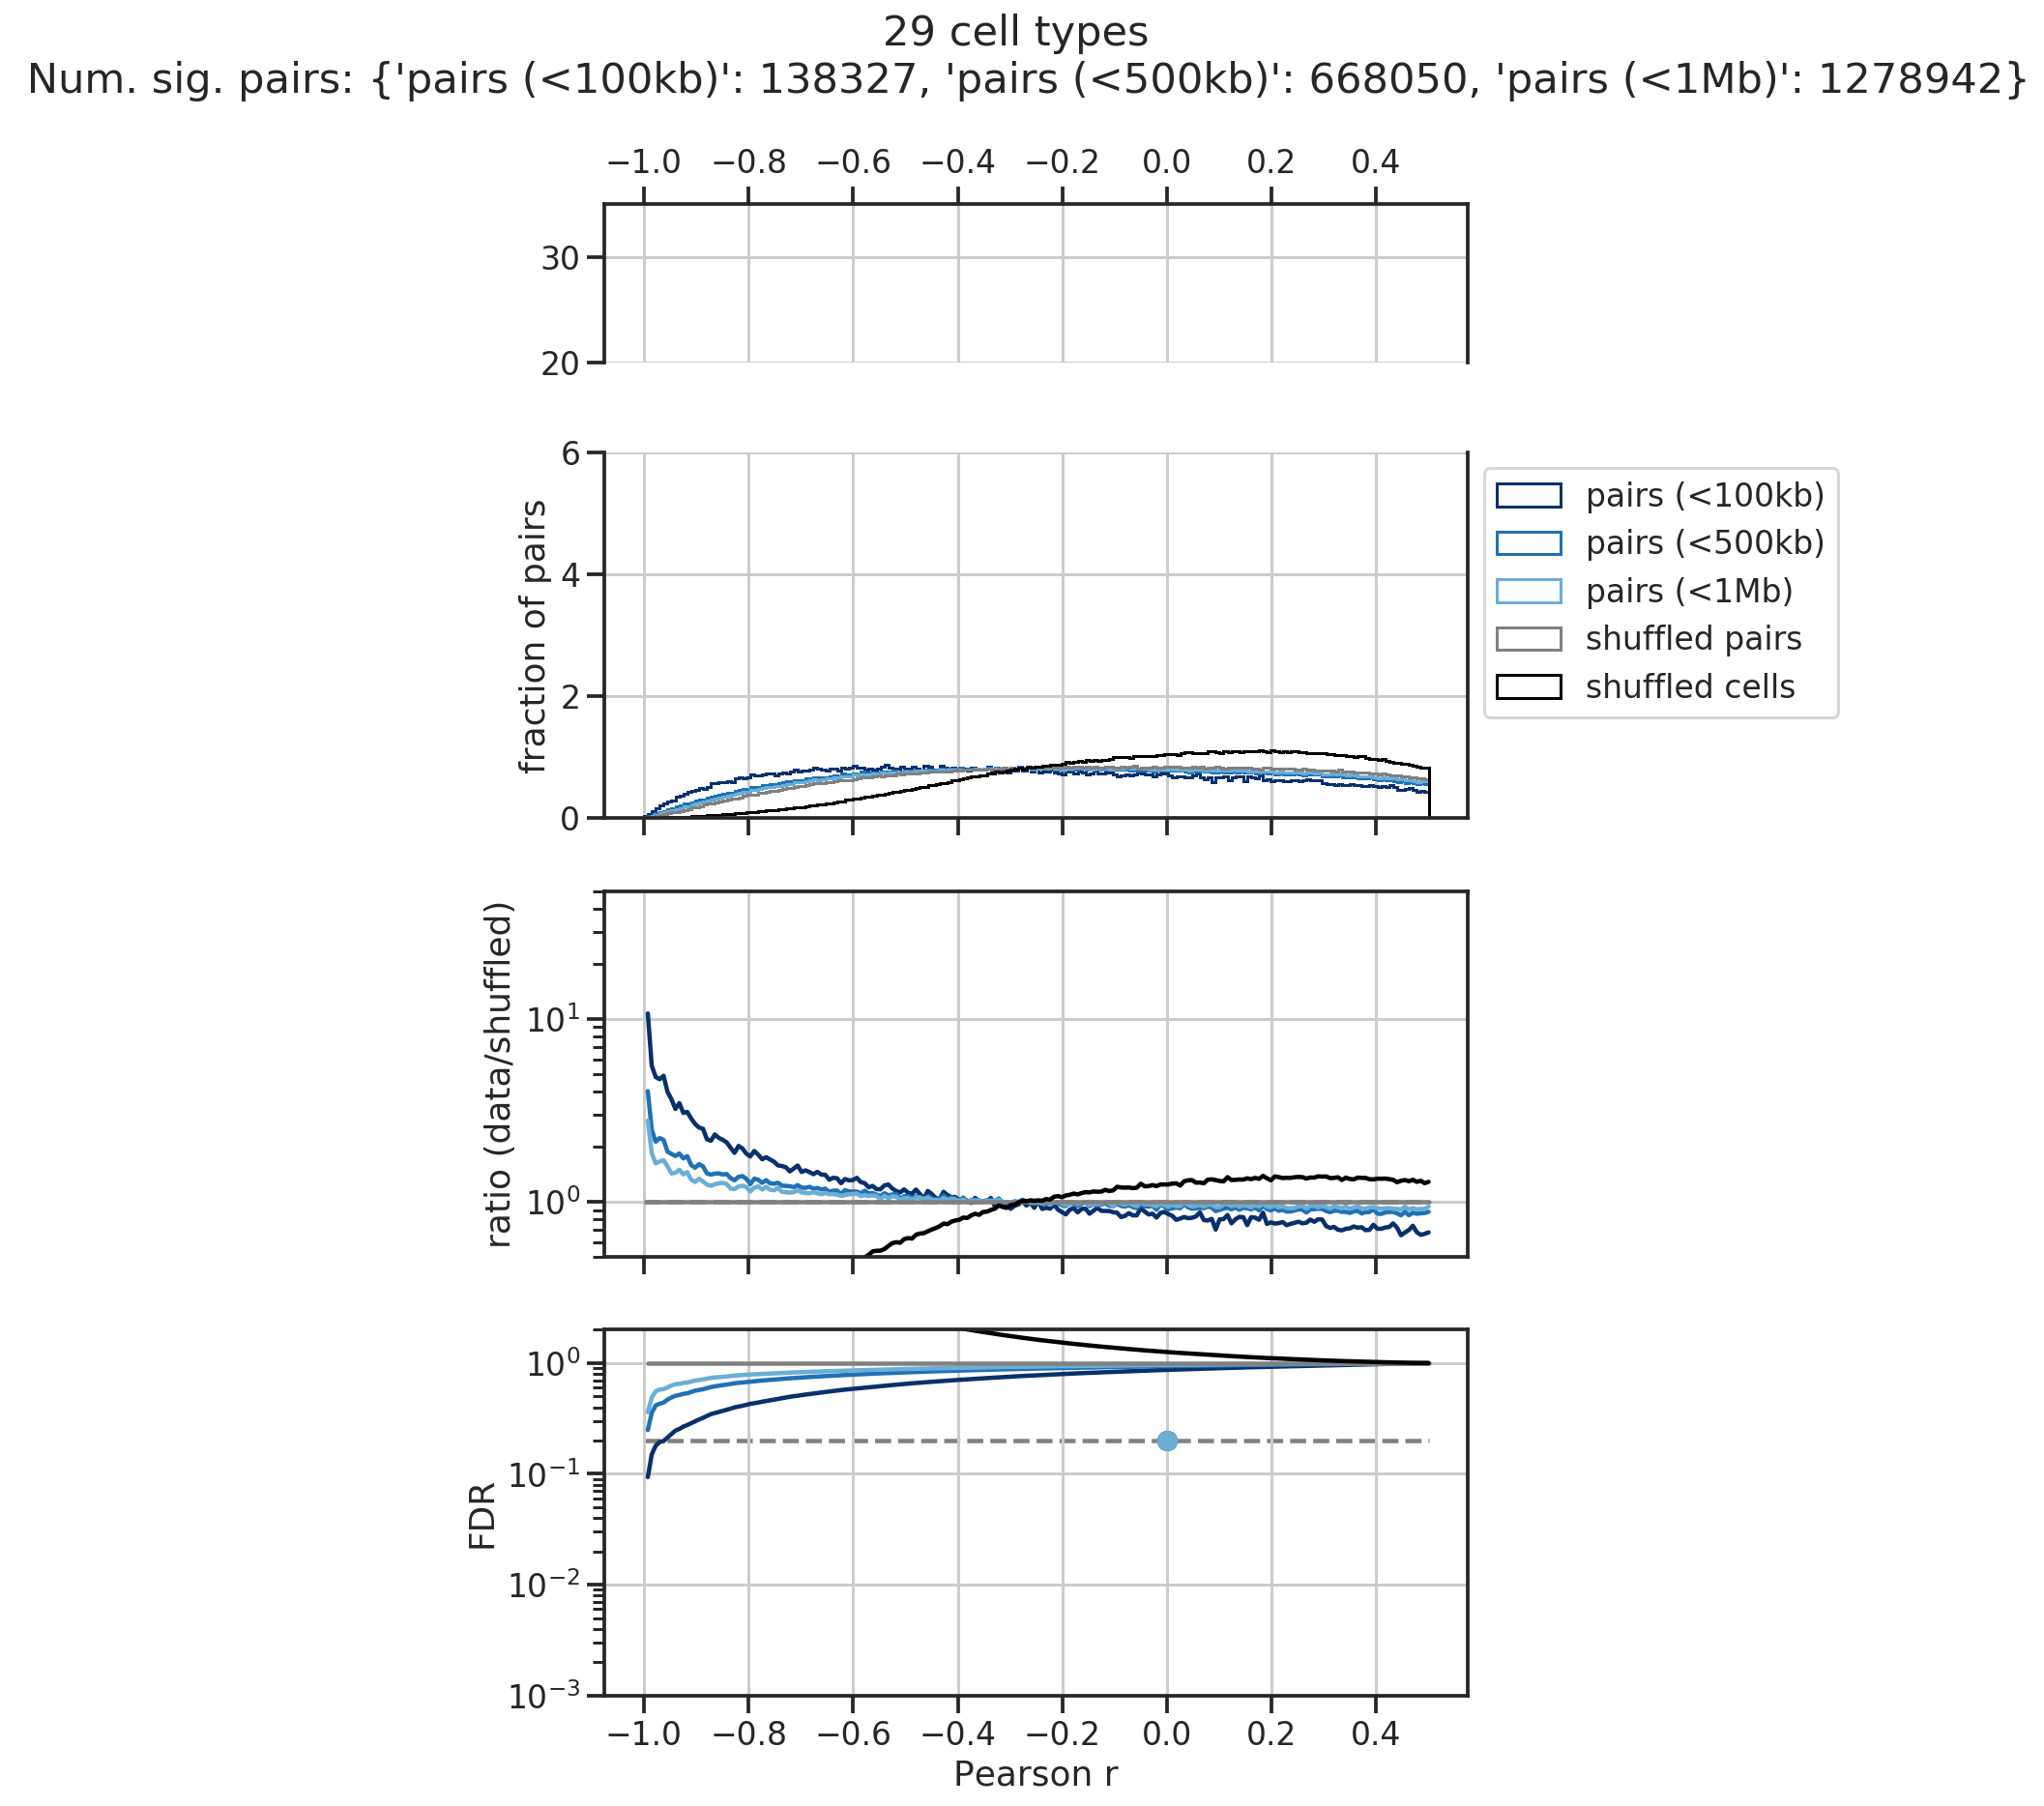

In [20]:
# figure 2
fig, axs = plt.subplots(4, 1, figsize=(4*2,4*4), sharex=True)
# fig.suptitle("k, ka = ({}, {})\n Num. sig. pairs: {}".format(k, ka, track_num_sigs), y=0.88)
fig.suptitle("29 cell types \n Num. sig. pairs: {}".format(track_num_sigs), y=0.88)

axs[0].axis('off')
ax = fig.add_subplot(912)
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.set_ylim([20, 35])
sns.despine(bottom=True, top=False, right=False, ax=ax)

ax = axs[1]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
ax.set_ylim([0, 6])
sns.despine(top=True, right=False, ax=ax)

ax = axs[2]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[3]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figures.format('corr_dist_plot_v2'))
plt.show()